# Exploring hurricane features and clustering methods

## Step 0: Same set up as the starter notebook

In [116]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)


Setup a subfolder for downloaded raw data and another subfolder for outputs. This prevents you from overwrites raw data by accident.

You can check that this new folder called 'data' was created. To view the files in your workspace, click on the 'File Browser' buttom at the left side-bar.

This folder will be used to store data which will be later downloaded.

---



In [117]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [118]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from sklearn.metrics import silhouette_score # to perform silhouette score
from collections import Counter # set operations
warnings.filterwarnings('ignore')

In [119]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


File downloaded successfully.


In [120]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:
    f.write(datatowrite)

## Step 1: Preparation: install packages, import packages and download data

### Import modules

In [121]:
!pip install minisom
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, OPTICS, Birch
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from minisom import MiniSom

scaler = StandardScaler()


# ----- Jerry Update
import joblib
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# alex update
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans

### Import IBTrACS dataset

In [122]:
!pip install netcdf4
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)
num_storms = tks.dims['storm']

### Map Background

In [123]:
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not`
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

## Step 2: Feature selection based on PDI

### Create feature selection datasets

In [124]:
pdi_df = pd.read_csv('PDI_max.csv')

In [125]:
vars_alltrack_df = pd.read_csv('Storm_Vars_alltrack.csv')

In [126]:
vars_storm_df = pd.read_csv('Storm_Vars_Storm.csv')

In [127]:
num_storms = tks.dims['storm']
feature_data = []

for i in range(num_storms):
    n_obs = int(tks.numobs.isel(storm=i).values)

    lat_vals = tks.lat.isel(storm=i, date_time=slice(0, n_obs)).values
    lon_vals = tks.lon.isel(storm=i, date_time=slice(0, n_obs)).values

    d2l_vals = tks.dist2land.isel(storm=i, date_time=slice(0, n_obs)).values

    # lon & lat & distance to land: take the first entry for each
    init_lat = lat_vals[0] if n_obs > 0 else np.nan
    init_lon = lon_vals[0] if n_obs > 0 else np.nan
    init_d2l = d2l_vals[0] if n_obs > 0 else np.nan

    # season: this is a single value per storm in IBTrACS
    storm_season = tks.season.isel(storm=i).values
    storm_season = int(storm_season) if not np.isnan(storm_season) else -999

    feature_data.append({
        "storm_id": i,
        "season": storm_season,
        "init_lat": init_lat,
        "init_lon": init_lon,
        "init_dist2land": init_d2l,
    })

initial_features_df = pd.DataFrame(feature_data)
print("shape of initial features_df:", initial_features_df.shape)

shape of initial features_df: (2344, 5)


In [128]:
candidate_features_df = pd.concat([initial_features_df, vars_storm_df], axis=1)

In [129]:
candidate_features_df.to_csv('candidate_features.csv')

In [130]:
features_df = pd.read_csv('candidate_features.csv')
features_df.dropna(subset=['PDI_max_usa'],inplace=True)
features_df

Unnamed: 0  storm_id  season   init_lat   init_lon  init_dist2land  \
0              0         0    1851  26.100000 -90.400010           335.0   
5              5         5    1851  13.366668 -47.200000          1093.0   
10            10        10    1851  32.500000 -73.500000           370.0   
13            13        13    1851  28.700000 -78.000000           244.0   
15            15        15    1852  20.633331 -67.333336           243.0   
...          ...       ...     ...        ...        ...             ...   
2339        2339      2339    2023  15.600000 -44.500000          1462.0   
2340        2340      2340    2023   9.600000 -30.199999          1494.0   
2341        2341      2341    2023  12.966667 -51.000000           869.0   
2342        2342      2342    2023  11.400000 -82.600000           111.0   
2343        2343      2343    2023  15.000000 -81.700000           150.0   

      PDI_max_wmo  PDI_max_usa  PDI_max_tokyo  Pres_min_wmo  ...  \
0     230400000.0  230400000.0            NaN           NaN  ...   
5     450000000.0  450000000.0            NaN           NaN  ...   
10     56250000.0   56250000.0            NaN           NaN  ...   
13     97200000.0   97200000.0            NaN           NaN  ...   
15    450000000.0  450000000.0            NaN         961.0  ...   
...           ...          ...            ...           ...  ...   
2339          NaN   41006248.0            NaN           NaN  ...   
2340          NaN   28800000.0            NaN           NaN  ...   
2341          NaN  382144288.0            NaN           NaN  ...   
2342          NaN    6250000.0            NaN           NaN  ...   
2343          NaN   12150000.0            NaN           NaN  ...   

      storm_speed_max_wmo  dist2land_intial  Lon_intial  Lat_intial  \
0                    10.0             335.0  -90.400009   26.100000   
5                    42.0            1093.0  -47.200001   13.366668   
10                    0.0             370.0  -73.500000   32.500000   
13                   18.0             244.0  -78.000000   28.700001   
15                   25.0             243.0  -67.333336   20.633331   
...                   ...               ...         ...         ...   
2339                 16.0            1462.0  -44.500000   15.600000   
2340                 14.0            1494.0  -30.199999    9.600000   
2341                 18.0             869.0  -51.000000   12.966667   
2342                  9.0             111.0  -82.599998   11.400000   
2343                 18.0             150.0  -81.699997   15.000000   

      lon_weighted  lat_weighted  lon_variance  lat_variance  \
0       -95.977188     28.109417     10.513896      1.790610   
5       -71.305283     27.337032    159.509905    113.445331   
10      -73.500000     32.500000      0.000000      0.000000   
13      -74.929146     33.427444      4.623666     14.761514   
15      -79.829987     27.812145     49.933213     29.701519   
...            ...           ...           ...           ...   
2339    -49.456161     20.863829     12.861205      9.304074   
2340    -41.333111     14.529725     36.979959      8.056544   
2341    -57.898663     23.753819     23.454986     47.987904   
2342    -83.502457     12.306846      0.272946      0.620407   
2343    -79.953651     16.796577      2.484947      1.959956   

      latlon_covariance  DayofYear_mean  
0             -4.143782      176.297297  
5             -1.327559      233.696970  
10             0.000000      257.451613  
13             7.975834      290.451613  
15            -3.927940      237.067416  
...                 ...             ...  
2339         -10.854178      272.677419  
2340         -17.081282      286.306122  
2341           3.895290      297.783019  
2342          -0.390260      296.600000  
2343           2.200520      320.909091  

[1963 rows x 23 columns]

In [131]:
features_df.columns

Index(['Unnamed: 0', 'storm_id', 'season', 'init_lat', 'init_lon',
       'init_dist2land', 'PDI_max_wmo', 'PDI_max_usa', 'PDI_max_tokyo',
       'Pres_min_wmo', 'r34_max_wmo', 'r50_max_wmo', 'r64_max_wmo',
       'storm_speed_max_wmo', 'dist2land_intial', 'Lon_intial', 'Lat_intial',
       'lon_weighted', 'lat_weighted', 'lon_variance', 'lat_variance',
       'latlon_covariance', 'DayofYear_mean'],
      dtype='object')

### Feature correlation

In [132]:
columns_used = ['PDI_max_usa', 'init_lat', 'init_lon','init_dist2land', 'Pres_min_wmo', 'storm_speed_max_wmo',
                'lon_weighted', 'lat_weighted', 'lon_variance','lat_variance', 'latlon_covariance', 'DayofYear_mean']

In [133]:
columns_corr = features_df[columns_used].corr()

<Axes: >

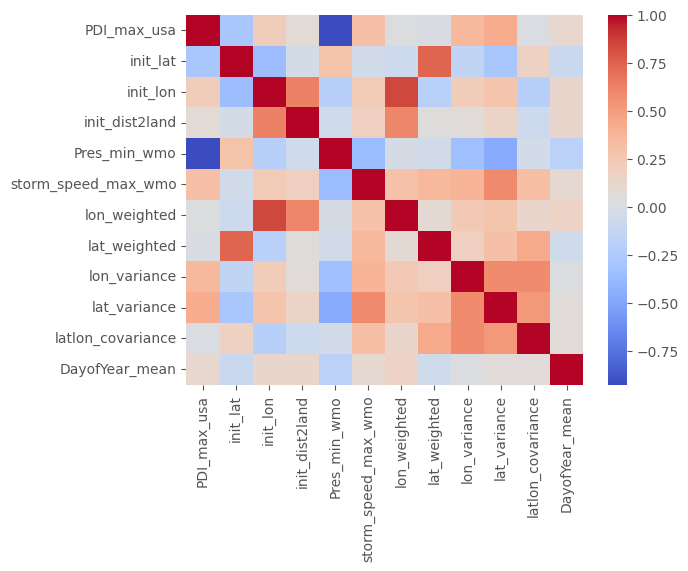

In [134]:
sns.heatmap(data = columns_corr, cmap = 'coolwarm')
# This heatmap shows clear negative correlation with Pres_min_wmo, which is physically intuitive.
# However, if Pres_min_wmo is from any time in the storm’s lifetime (not only the initial state),
# it might be tautologically correlated with high final intensity (and thus high PDI)
# We still want to use min pressure despite of this to in the study of feature importance.

### Build features

In [135]:
def build_Xy(df, feature_cols, target_col='PDI_max_usa'):
    df_subset = df[feature_cols].copy()
    # fill na with mean:
    for col in feature_cols:
        df_subset[col] = df_subset[col].fillna(df_subset[col].mean())
    predictor_cols = [x for x in feature_cols if x != target_col]
    X = df_subset[predictor_cols].copy()
    y = df_subset[target_col].copy()

    return X, y

In [136]:
X, y = build_Xy(features_df, feature_cols=columns_used, target_col='PDI_max_usa')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Simple linear regression

In [137]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

train_score = linreg.score(X_train, y_train)
test_score = linreg.score(X_test, y_test)

print("linear regression")
print("train R^2:", train_score)
print("test R^2:", test_score)

print("coefficients: ")
coef_dict = zip(X.columns, linreg.coef_)
for feature, coef in coef_dict:
    print(f"{feature}: {coef}")

print("intercept:", linreg.intercept_)

linear regression
train R^2: 0.7307258971787837
test R^2: 0.7280858154966457
coefficients: 
init_lat: -2684166.5173710342
init_lon: 1242595.7661174564
init_dist2land: 16114.511760400692
Pres_min_wmo: -10809974.231863497
storm_speed_max_wmo: 1091628.45183507
lon_weighted: -2327756.51854208
lat_weighted: 2043972.188007621
lon_variance: 282681.62296632316
lat_variance: 305412.939609037
latlon_covariance: -479611.8270995628
DayofYear_mean: 119039.46911525216
intercept: 10638380198.173346


### Random forest

In [138]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

train_score_rf = rf.score(X_train, y_train)
test_score_rf = rf.score(X_test, y_test)
print("random forest regressor")
print("train R^2:", train_score_rf)
print("test R^2:", test_score_rf)

importances = rf.feature_importances_
for feat_name, imp in zip(X.columns, importances):
    print(f"{feat_name} importance: {imp:.4f}")

random forest regressor
train R^2: 0.9761559840338515
test R^2: 0.813363666640597
init_lat importance: 0.0152
init_lon importance: 0.0114
init_dist2land importance: 0.0128
Pres_min_wmo importance: 0.8138
storm_speed_max_wmo importance: 0.0132
lon_weighted importance: 0.0139
lat_weighted importance: 0.0197
lon_variance importance: 0.0192
lat_variance importance: 0.0489
latlon_covariance importance: 0.0181
DayofYear_mean importance: 0.0137


### PCA

In [139]:
# combine train + test for a PCA on the entire dataset
# because PCA is unsupervised, we can just do it on X to see overall structure
X_full = pd.concat([X_train, X_test])
scaler_pca = StandardScaler()
X_full_scaled = scaler_pca.fit_transform(X_full)

pca = PCA(n_components=3)
pca.fit(X_full_scaled)

print("PCA results (3 components):")
print("explained variance ratio:", pca.explained_variance_ratio_)

# optionally transform X to get principal components
X_pcs = pca.transform(X_full_scaled)

PCA results (3 components):
explained variance ratio: [0.29866344 0.21695998 0.15144609]


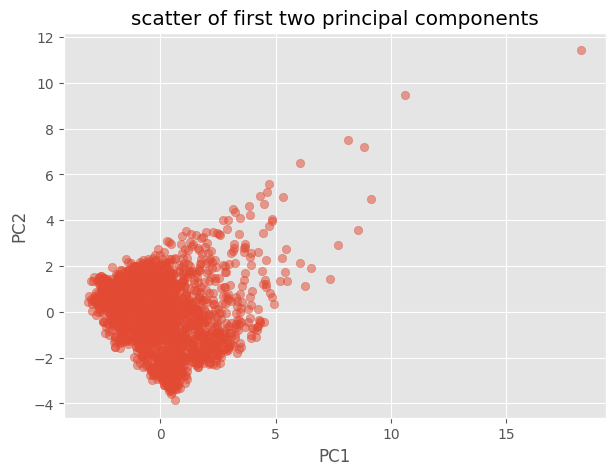

In [140]:
plt.figure(figsize=(7,5))
plt.scatter(X_pcs[:,0], X_pcs[:,1], alpha=0.5)
plt.title("scatter of first two principal components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
# there isn't a particularly clear clustering pattern from the two principal components

In [141]:
loadings = pca.components_.T  # shape (n_features, n_components)
for i, col in enumerate(X.columns):
    print(f"feature {col}: PC1 loading={loadings[i,0]:.3f}, PC2 loading={loadings[i,1]:.3f}, PC3 loading={loadings[i,2]:.3f}")


feature init_lat: PC1 loading=-0.121, PC2 loading=0.390, PC3 loading=-0.538
feature init_lon: PC1 loading=0.352, PC2 loading=-0.438, PC3 loading=-0.177
feature init_dist2land: PC1 loading=0.276, PC2 loading=-0.286, PC3 loading=-0.399
feature Pres_min_wmo: PC1 loading=-0.236, PC2 loading=-0.009, PC3 loading=-0.359
feature storm_speed_max_wmo: PC1 loading=0.382, PC2 loading=0.158, PC3 loading=0.030
feature lon_weighted: PC1 loading=0.380, PC2 loading=-0.253, PC3 loading=-0.366
feature lat_weighted: PC1 loading=0.152, PC2 loading=0.485, PC3 loading=-0.380
feature lon_variance: PC1 loading=0.377, PC2 loading=0.188, PC3 loading=0.226
feature lat_variance: PC1 loading=0.441, PC2 loading=0.158, PC3 loading=0.237
feature latlon_covariance: PC1 loading=0.259, PC2 loading=0.426, PC3 loading=0.059
feature DayofYear_mean: PC1 loading=0.115, PC2 loading=-0.096, PC3 loading=0.024


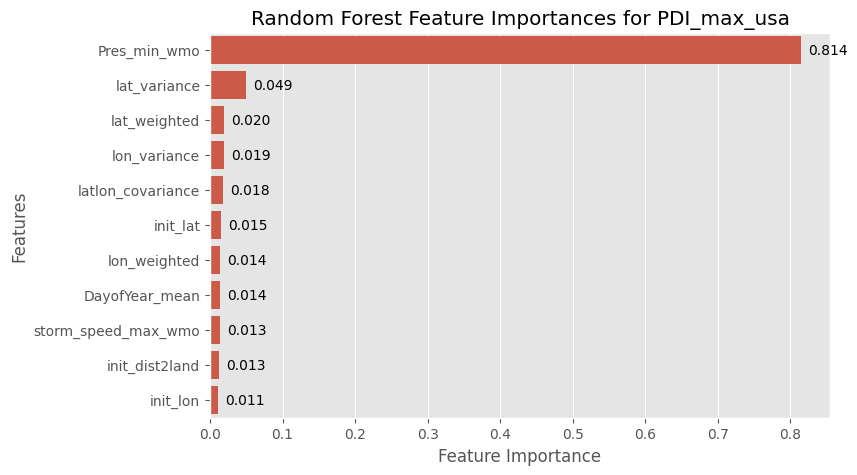

In [142]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # descending sort
feature_names = X.columns[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sorted_importances, y=feature_names, orient='h')

# Annotate each bar with its importance value
for i, v in enumerate(sorted_importances):
    ax.text(v + 0.01, i, f"{v:.3f}", va='center')

plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importances for PDI_max_usa")
plt.show()

### 2.4 XGBoost

#### 2.4.1 Prepare Data for Training

In [143]:
df_storm = pd.read_csv('Storm_Vars_Storm.csv')

moment_array = df_storm.iloc[:, 11:16].to_numpy()
PDI_max = df_storm['PDI_max_usa'].values.ravel()
DayofYear_mean = df_storm.DayofYear_mean.values
Pres_min_wmo = df_storm.Pres_min_wmo.values

moment_array = np.array(moment_array)  # Shape (L, 5)
DayofYear_mean = np.array(df_storm.DayofYear_mean.values).reshape(-1, 1)  # Shape (L, 1)
Pres_min_wmo = np.array(df_storm.Pres_min_wmo.values).reshape(-1, 1)  # Shape (L, 1)
dist2land_intial = np.array(df_storm.dist2land_intial.values).reshape(-1, 1)  # Shape (L, 1)
Lon_intial = np.array(df_storm.Lon_intial.values).reshape(-1, 1)  # Shape (L, 1)
Lat_intial = np.array(df_storm.Lat_intial.values).reshape(-1, 1)  # Shape (L, 1)

X_expanded = np.hstack((moment_array, DayofYear_mean, Pres_min_wmo,
                        dist2land_intial, Lon_intial, Lat_intial))  # Shape (L, 7)

# 80% Training, 20% Testing
nan_mask = np.logical_and(~np.isnan(X_expanded).any(axis=1) , ~np.isnan(PDI_max) )  # Mask where all values are non-NaN
X = X_expanded[nan_mask]
y = PDI_max[nan_mask]
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Standardize to zero mean, unit variance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### 2.4.2 Train Model with Bayesian Optimization (RUN ONLY ONCE)

In [144]:
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# param_grid = {
#     'n_estimators': [100, 300, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [4, 6, 8], 'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0], 'reg_alpha': [0.01, 0.1, 1.0], 'reg_lambda': [0.1, 0.5, 1.0]
# }

# # Perform Grid Search
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
#                            scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# # Train Model
# best_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
# best_xgb.fit(X_train, y_train)
# xgb_model = best_xgb

# # Save Model
# xgb_model.save_model("XGBoost_model_moment_presmin.json")  # Save as JSON format (recommended)

#### 2.4.3 Evaluate Model & Get Feature Importance

1.2.2


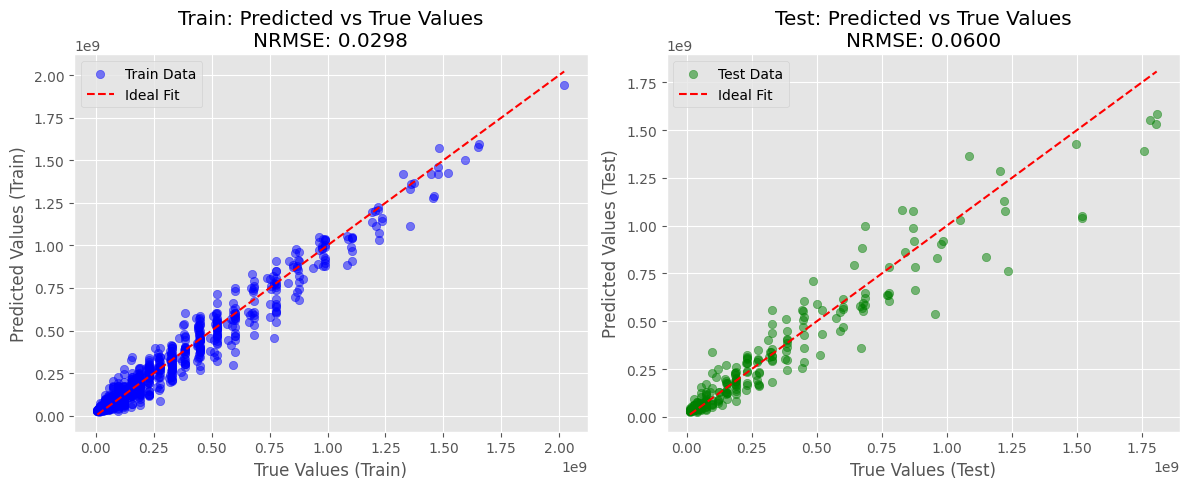

In [145]:
import sklearn
print(sklearn.__version__)
!pip install scikit-learn==1.2.2

# Load Model
xgb_model = XGBRegressor()
xgb_model.load_model("XGBoost_model_moment_presmin.json")

# Predict on training and testing sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Compute RMSE
nrmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)) / (y_train.max() - y_train.min())
nrmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)) / (y_test.max() - y_test.min())

# Create scatter plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue', label='Train Data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red', label='Ideal Fit')
plt.xlabel("True Values (Train)")
plt.ylabel("Predicted Values (Train)")
plt.title(f"Train: Predicted vs True Values\nNRMSE: {nrmse_train:.4f}")
plt.legend()
# ....
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green', label='Test Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Ideal Fit')
plt.xlabel("True Values (Test)")
plt.ylabel("Predicted Values (Test)")
plt.title(f"Test: Predicted vs True Values\nNRMSE: {nrmse_test:.4f}")
plt.legend()
# .......
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 800x500 with 0 Axes>

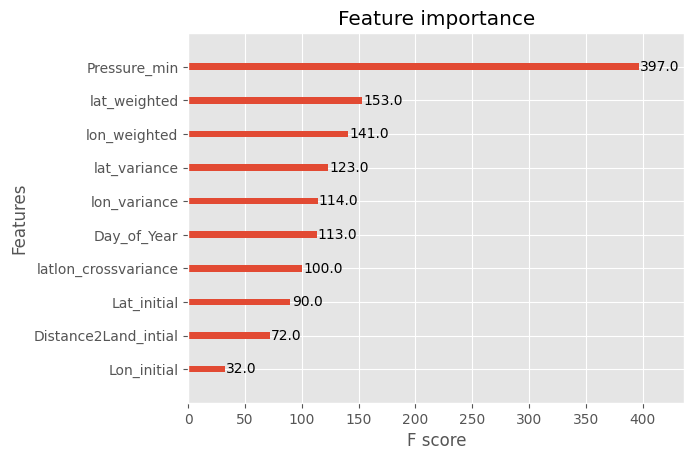

In [146]:
# Feature Importance
feature_names = ['lon_weighted', 'lat_weighted', 'lon_variance', 'lat_variance', 'latlon_crossvariance',
                 'Day_of_Year','Pressure_min','Distance2Land_intial', 'Lon_initial', 'Lat_initial']
plt.figure(figsize=(8, 5))
# ax=xgb.plot_importance(xgb_model, importance_type='weight', title="Feature Importance", xlabel="F Score")
# ax.set_yticklabels(np.flip(feature_names))
xgb_model.get_booster().feature_names = feature_names
xgb.plot_importance(xgb_model.get_booster())

#### 2.4.4 Re-scaled Variables based on feature importance

In [147]:
# Re-scaled Variables based on feature importance
f_scores_dict = xgb_model.get_booster().get_score(importance_type='weight')
f_scores_ordered = [f_scores_dict.get(feature, 0) for feature in feature_names]

normalized_f_scores = 1 + 9 * (f_scores_ordered / np.max(f_scores_ordered))  # Scale between 1 and 10
X_rescaled = X * normalized_f_scores  # Element-wise multiplication
print("Feature Importance Scaling Factors:")
for feature, factor in zip(feature_names, normalized_f_scores):
    print(f"{feature}: {factor}")

Feature Importance Scaling Factors:
lon_weighted: 4.19647355163728
lat_weighted: 4.468513853904282
lon_variance: 3.584382871536524
lat_variance: 3.788413098236776
latlon_crossvariance: 3.2670025188916876
Day_of_Year: 3.5617128463476067
Pressure_min: 10.0
Distance2Land_intial: 2.6322418136020147
Lon_initial: 1.7254408060453401
Lat_initial: 3.040302267002519


## Step 3: Clustering algorithms

In [148]:
# @ALEX: please use this as input, I assume you need a list. If not, please comment out the line. --- Jerry
        # The shape should be (1204, 10)!!!
moment_lst_rescaled = X_rescaled     # this is an array now
#moment_lst_rescaled = moment_lst_rescaled.tolist()
np.shape(moment_lst_rescaled)


(1204, 10)

### Find inertia values to determine the right number of clusters

Has the idea number of clusters changed?

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

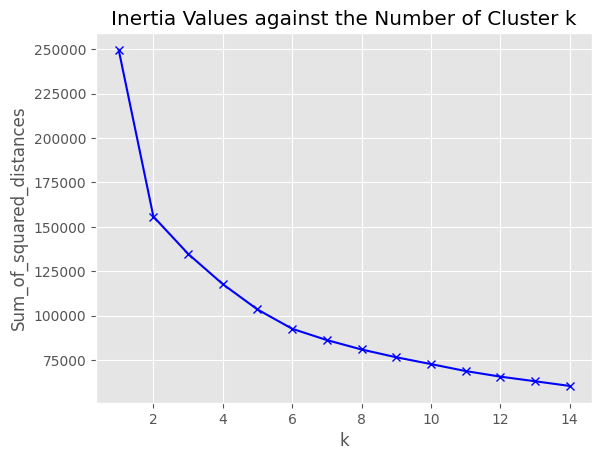

In [149]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst_rescaled, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

### Plotting Functions

In [150]:
def cluster_pie(labels, num_clusters, title='Cluster Distribution'):
    """
    Plots a pie chart showing the distribution of clusters.

    Parameters:
    - labels: List or array of cluster assignments.
    - num_clusters: Total number of clusters.
    - title: Title of the pie chart (default: 'Cluster Distribution').
    """
    cluster_counts = [np.sum(np.array(labels) == i) for i in range(num_clusters)]

    cmap = plt.get_cmap("tab10")
    colors = cmap(np.linspace(0, 1, num_clusters))  # Ensure color consistency with the tab10 palette

    plt.figure(figsize=(7, 7))
    plt.pie(cluster_counts, labels=[f'Cluster {i}' for i in range(num_clusters)],
            autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(title)
    plt.show()

In [151]:
# Check the initial data distribution
print("Initial data ranges:")
print(f"X range: {np.min(moment_lst_rescaled[:, 0])} to {np.max(moment_lst_rescaled[:, 0])}")
print(f"Y range: {np.min(moment_lst_rescaled[:, 1])} to {np.max(moment_lst_rescaled[:, 1])}")

# Before k-means, standardize the data properly
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
moment_lst_standardized = scaler.fit_transform(moment_lst_rescaled)

# Check standardized distribution
print("\nStandardized ranges:")
print(f"X range: {np.min(moment_lst_standardized[:, 0])} to {np.max(moment_lst_standardized[:, 0])}")
print(f"Y range: {np.min(moment_lst_standardized[:, 1])} to {np.max(moment_lst_standardized[:, 1])}")

# Apply k-means on standardized data
kmeans = KMeans(n_clusters=6, random_state=0)
labels_kmeans = kmeans.fit_predict(moment_lst_standardized)

# Get cluster centers and transform back
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("\nCluster centers (original scale):")
for i, center in enumerate(centers):
    print(f"Cluster {i}: ({center[0]}, {center[1]})")

# Transform to geographic coordinates
def transform_to_geo(data):
    geo_coords = np.zeros_like(data)
    geo_coords[:, 0] = data[:, 0] * 180  # Scale to full longitude range
    geo_coords[:, 1] = data[:, 1] * 90   # Scale to full latitude range
    return geo_coords

moment_lst_geo = transform_to_geo(moment_lst_standardized)

Initial data ranges:
X range: -8.1364502209729 to 11.494747545852775
Y range: -10.955443813964546 to 15.703634135866393

Standardized ranges:
X range: -1.9388779938332752 to 2.7391445232314204
Y range: -2.4516974036887995 to 3.5142856549825057

Cluster centers (original scale):
Cluster 0: (-3.3708258078608853, 2.003476767362001)
Cluster 1: (1.8831217701769363, -0.8545986134510706)
Cluster 2: (4.2265737367619085, -5.958365152001279)
Cluster 3: (-3.3258892997391296, -1.9644775862156354)
Cluster 4: (3.2306851444346973, 4.569889233717306)
Cluster 5: (3.3105212590197213, 5.860311138198612)


### Clustering

#### K-Means

Shape of moment_lst_rescaled: (1204, 10)


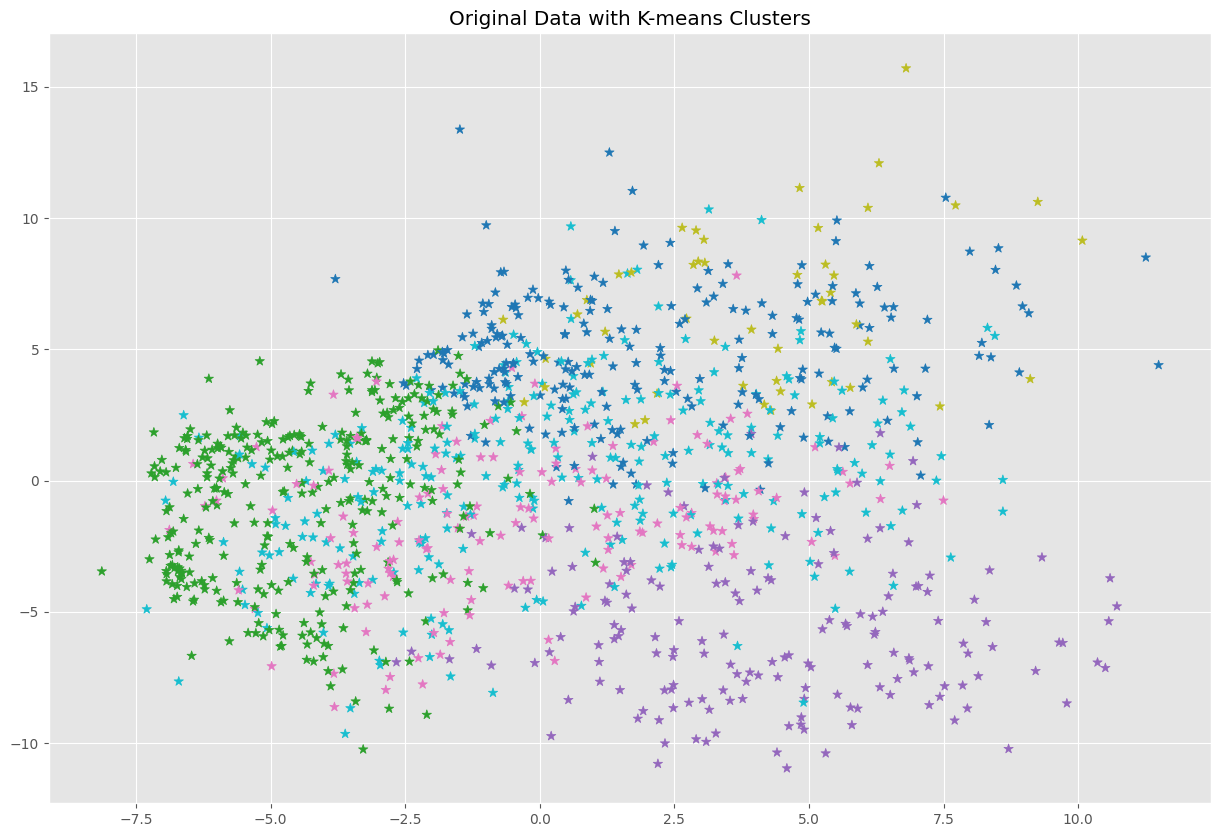

<Figure size 1500x1000 with 0 Axes>

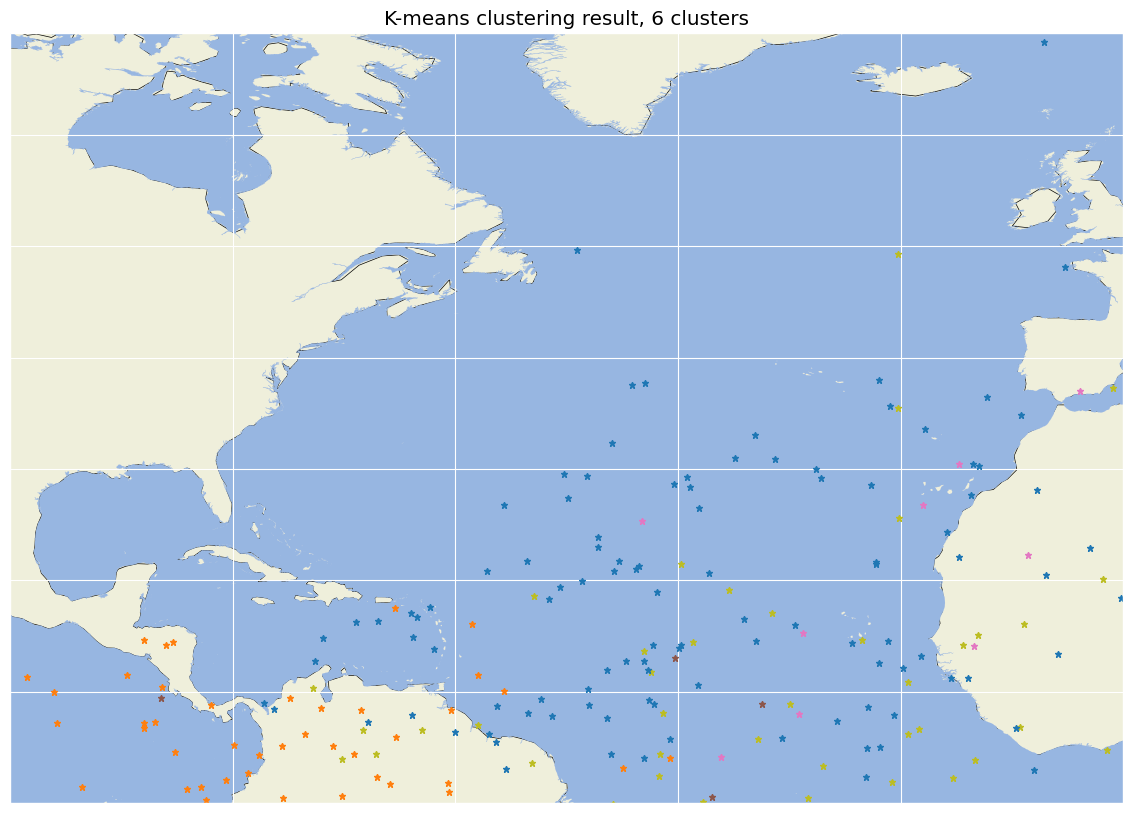


Cluster sizes:
Cluster 0: 230 points
Cluster 1: 326 points
Cluster 2: 172 points
Cluster 3: 150 points
Cluster 4: 49 points
Cluster 5: 277 points


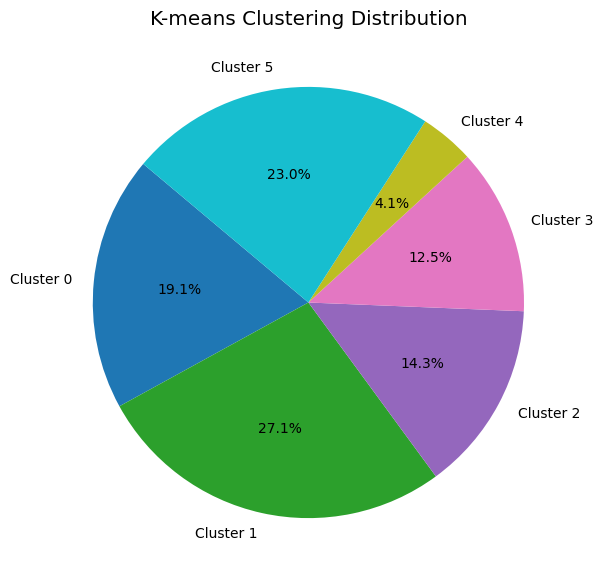

In [152]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

print("Shape of moment_lst_rescaled:", moment_lst_rescaled.shape)

x_min, x_max = np.min(moment_lst_rescaled[:, 0]), np.max(moment_lst_rescaled[:, 0])
y_min, y_max = np.min(moment_lst_rescaled[:, 1]), np.max(moment_lst_rescaled[:, 1])

original_ranges = {
    'x': (x_min, x_max),
    'y': (y_min, y_max)
}

def transform_to_geo(data, original_ranges):
    x_min, x_max = original_ranges['x']
    y_min, y_max = original_ranges['y']

    geo_x_min, geo_x_max = -180, 180
    geo_y_min, geo_y_max = -90, 90

    geo_coords = np.zeros_like(data)

    geo_coords[:, 0] = (data[:, 0] - x_min) / (x_max - x_min) * (geo_x_max - geo_x_min) + geo_x_min
    geo_coords[:, 1] = (data[:, 1] - y_min) / (y_max - y_min) * (geo_y_max - geo_y_min) + geo_y_min

    return geo_coords

kmeans = KMeans(n_clusters=6, random_state=0)
labels_kmeans = kmeans.fit_predict(moment_lst_rescaled)

inertia = kmeans.inertia_
silhouette_avg = silhouette_score(moment_lst_rescaled, labels_kmeans)

cluster_comp = pd.DataFrame(columns=["method", "SSD", "silhouette_avg"])
cluster_comp = pd.concat([cluster_comp, pd.DataFrame([{
    "method": "K-means",
    "SSD": inertia,
    "silhouette_avg": silhouette_avg
}])], ignore_index=True)

moment_lst_geo = transform_to_geo(moment_lst_rescaled, original_ranges)

plt.figure(figsize=(15, 10))
plt.scatter(moment_lst_rescaled[:, 0], moment_lst_rescaled[:, 1],
           c=labels_kmeans,
           cmap='tab10',
           marker='*',
           s=50)
plt.title('Original Data with K-means Clusters')
plt.show()

plt.figure(figsize=(15, 10))
cmap = plt.get_cmap("tab10")
ax = map_background()

for i in range(len(moment_lst_geo)):
    ax.plot(moment_lst_geo[i, 0], moment_lst_geo[i, 1],
            color=cmap(labels_kmeans[i]/6),
            marker='*',
            markersize=5)

plt.title('K-means clustering result, 6 clusters')
plt.show()

unique, counts = np.unique(labels_kmeans, return_counts=True)
print("\nCluster sizes:")
for i, count in zip(unique, counts):
    print(f"Cluster {i}: {count} points")

cluster_pie(labels_kmeans, num_clusters=6, title='K-means Clustering Distribution')

#### Agglomerative Clustering

Shape of moment_lst_rescaled: (1204, 10)


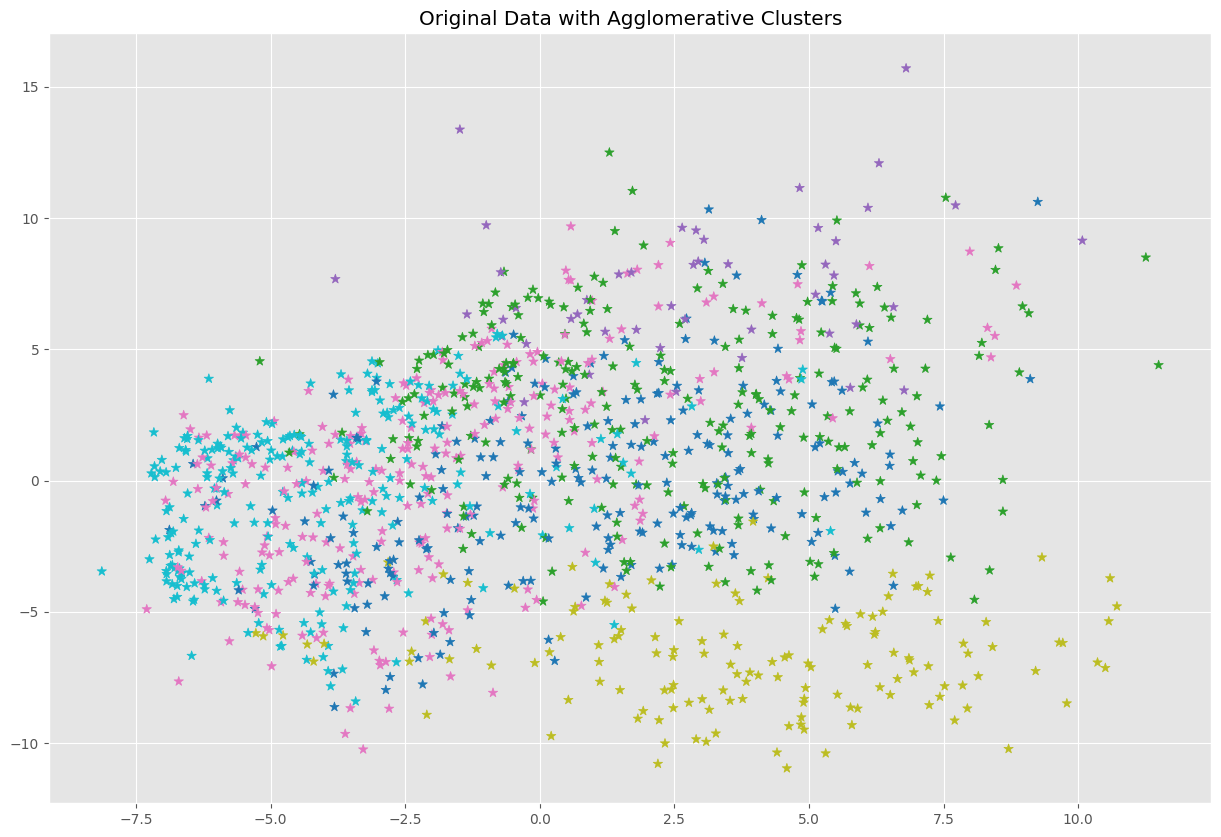

<Figure size 1500x1000 with 0 Axes>

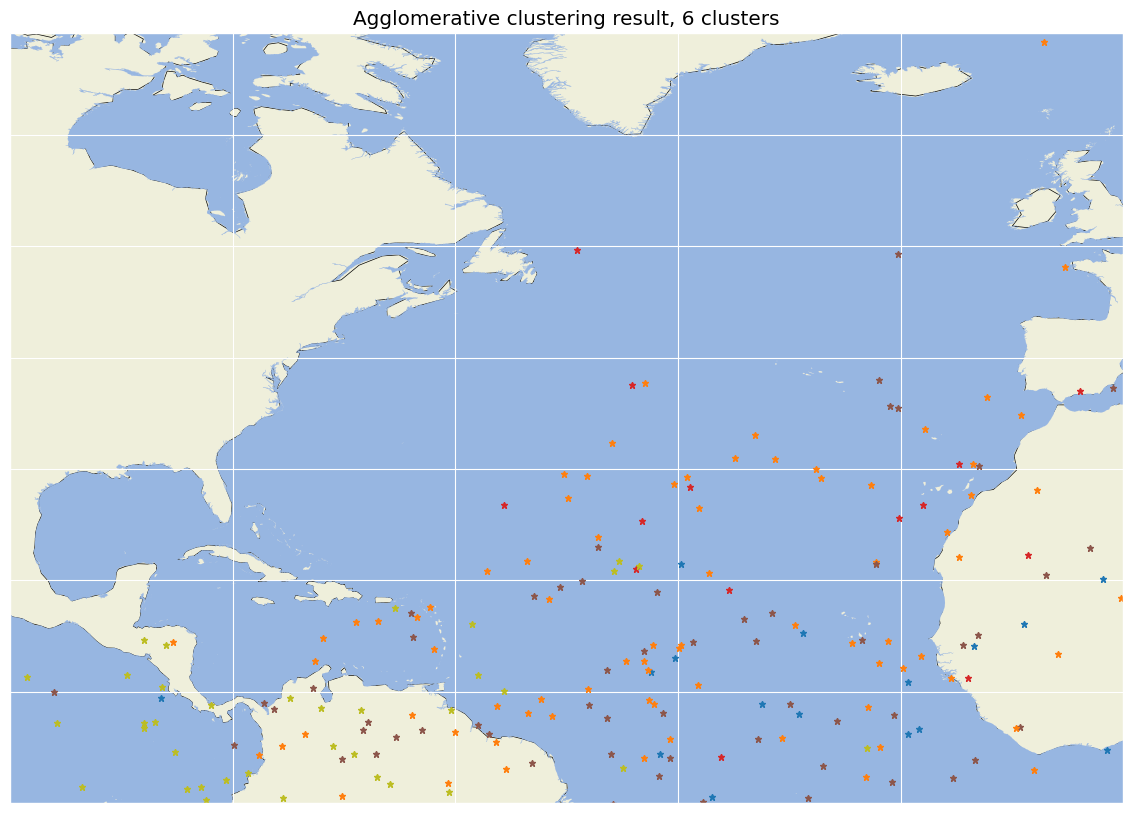


Cluster sizes:
Cluster 0: 232 points
Cluster 1: 264 points
Cluster 2: 47 points
Cluster 3: 267 points
Cluster 4: 143 points
Cluster 5: 251 points


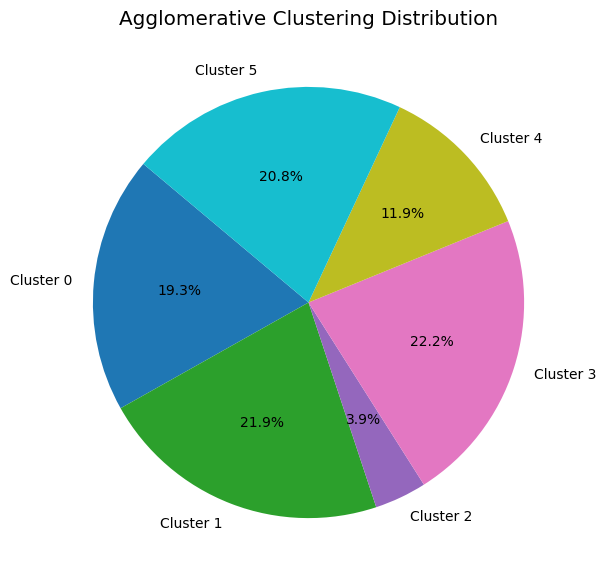

In [166]:
from sklearn.cluster import AgglomerativeClustering

print("Shape of moment_lst_rescaled:", moment_lst_rescaled.shape)

x_min, x_max = np.min(moment_lst_rescaled[:, 0]), np.max(moment_lst_rescaled[:, 0])
y_min, y_max = np.min(moment_lst_rescaled[:, 1]), np.max(moment_lst_rescaled[:, 1])

original_ranges = {
    'x': (x_min, x_max),
    'y': (y_min, y_max)
}

def transform_to_geo(data, original_ranges):
    x_min, x_max = original_ranges['x']
    y_min, y_max = original_ranges['y']

    geo_x_min, geo_x_max = -180, 180
    geo_y_min, geo_y_max = -90, 90

    geo_coords = np.zeros_like(data)

    geo_coords[:, 0] = (data[:, 0] - x_min) / (x_max - x_min) * (geo_x_max - geo_x_min) + geo_x_min
    geo_coords[:, 1] = (data[:, 1] - y_min) / (y_max - y_min) * (geo_y_max - geo_y_min) + geo_y_min

    return geo_coords

agg_clustering = AgglomerativeClustering(n_clusters=6)
labels_agg = agg_clustering.fit_predict(moment_lst_rescaled)

centroids = np.array([moment_lst_rescaled[labels_agg == i].mean(axis=0) for i in range(6)])
squared_distances = np.sum([np.linalg.norm(moment_lst_rescaled[i] - centroids[labels_agg[i]])**2
                          for i in range(len(moment_lst_rescaled))])
silhouette_avg_agg = silhouette_score(moment_lst_rescaled, labels_agg)

cluster_comp = pd.DataFrame(columns=["method", "SSD", "silhouette_avg"])
cluster_comp = pd.concat([cluster_comp, pd.DataFrame([{
    "method": "Agglomerative",
    "SSD": squared_distances,
    "silhouette_avg": silhouette_avg_agg
}])], ignore_index=True)

moment_lst_geo = transform_to_geo(moment_lst_rescaled, original_ranges)

plt.figure(figsize=(15, 10))
plt.scatter(moment_lst_rescaled[:, 0], moment_lst_rescaled[:, 1],
           c=labels_agg,
           cmap='tab10',
           marker='*',
           s=50)
plt.title('Original Data with Agglomerative Clusters')
plt.show()

plt.figure(figsize=(15, 10))
cmap = plt.get_cmap("tab10")
ax = map_background()

for i in range(len(moment_lst_geo)):
    ax.plot(moment_lst_geo[i, 0], moment_lst_geo[i, 1],
            color=cmap(labels_agg[i]/6),
            marker='*',
            markersize=5)

plt.title('Agglomerative clustering result, 6 clusters')
plt.show()

unique, counts = np.unique(labels_agg, return_counts=True)
print("\nCluster sizes:")
for i, count in zip(unique, counts):
    print(f"Cluster {i}: {count} points")

cluster_pie(labels_agg,num_clusters=6, title='Agglomerative Clustering Distribution')


Shape of moment_lst_rescaled: (1204, 10)


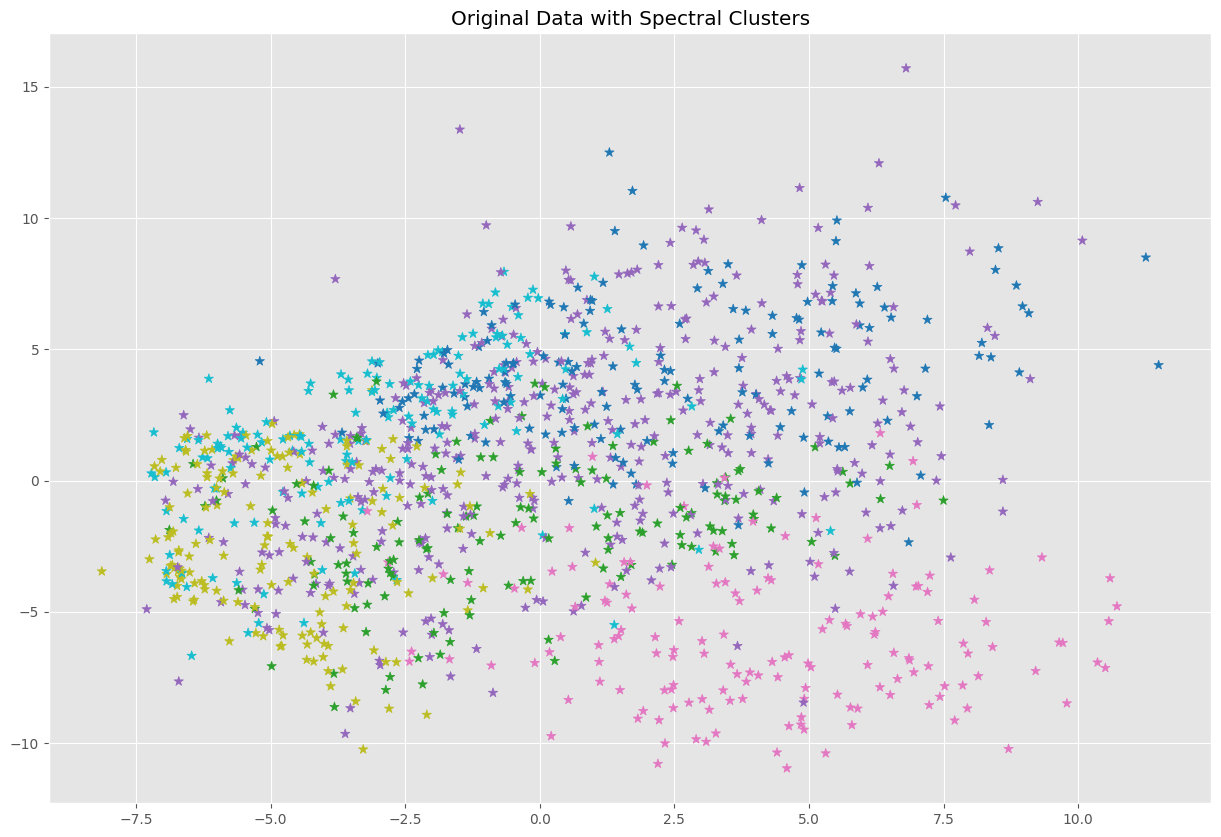

<Figure size 1500x1000 with 0 Axes>

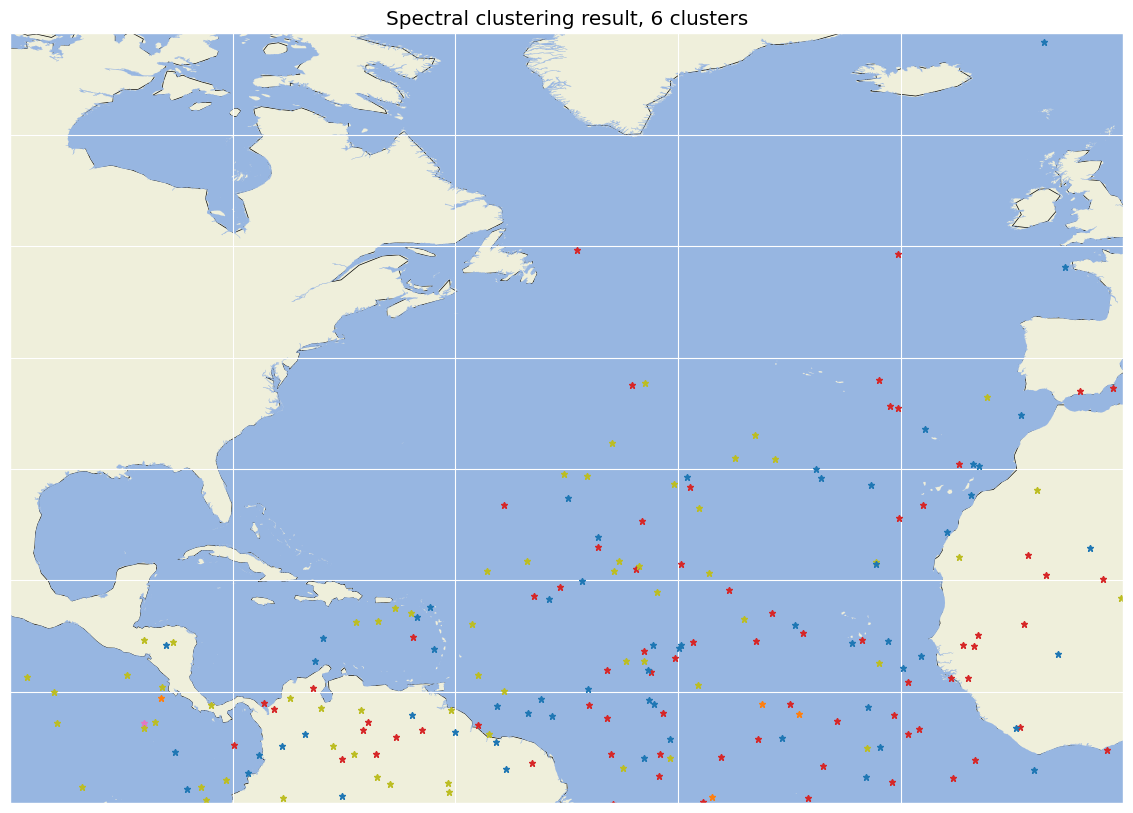


Cluster sizes:
Cluster 0: 165 points
Cluster 1: 148 points
Cluster 2: 424 points
Cluster 3: 155 points
Cluster 4: 159 points
Cluster 5: 153 points


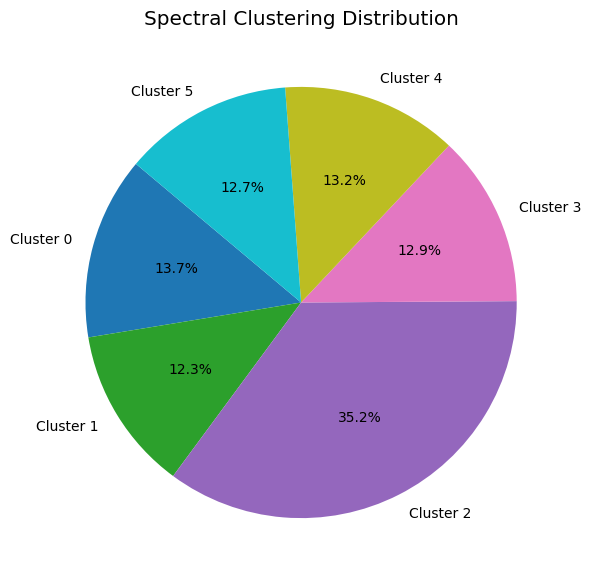

In [154]:
from sklearn.cluster import SpectralClustering

print("Shape of moment_lst_rescaled:", moment_lst_rescaled.shape)

x_min, x_max = np.min(moment_lst_rescaled[:, 0]), np.max(moment_lst_rescaled[:, 0])
y_min, y_max = np.min(moment_lst_rescaled[:, 1]), np.max(moment_lst_rescaled[:, 1])

original_ranges = {
   'x': (x_min, x_max),
   'y': (y_min, y_max)
}

def transform_to_geo(data, original_ranges):
   x_min, x_max = original_ranges['x']
   y_min, y_max = original_ranges['y']

   geo_x_min, geo_x_max = -180, 180
   geo_y_min, geo_y_max = -90, 90

   geo_coords = np.zeros_like(data)

   geo_coords[:, 0] = (data[:, 0] - x_min) / (x_max - x_min) * (geo_x_max - geo_x_min) + geo_x_min

   geo_coords[:, 1] = (data[:, 1] - y_min) / (y_max - y_min) * (geo_y_max - geo_y_min) + geo_y_min

   return geo_coords

spectral = SpectralClustering(n_clusters=6, affinity='nearest_neighbors', random_state=0)
labels_spectral = spectral.fit_predict(moment_lst_rescaled)

centroids = np.array([moment_lst_rescaled[labels_spectral == i].mean(axis=0) for i in range(6)])
squared_distances = np.sum([np.linalg.norm(moment_lst_rescaled[i] - centroids[labels_spectral[i]])**2
                         for i in range(len(moment_lst_rescaled))])
silhouette_avg_spectral = silhouette_score(moment_lst_rescaled, labels_spectral)

cluster_comp = pd.DataFrame(columns=["method", "SSD", "silhouette_avg"])
cluster_comp = pd.concat([cluster_comp, pd.DataFrame([{
   "method": "Spectral",
   "SSD": squared_distances,
   "silhouette_avg": silhouette_avg_spectral
}])], ignore_index=True)

moment_lst_geo = transform_to_geo(moment_lst_rescaled, original_ranges)

plt.figure(figsize=(15, 10))
plt.scatter(moment_lst_rescaled[:, 0], moment_lst_rescaled[:, 1],
          c=labels_spectral,
          cmap='tab10',
          marker='*',
          s=50)
plt.title('Original Data with Spectral Clusters')
plt.show()

plt.figure(figsize=(15, 10))
cmap = plt.get_cmap("tab10")
ax = map_background()

for i in range(len(moment_lst_geo)):
   ax.plot(moment_lst_geo[i, 0], moment_lst_geo[i, 1],
           color=cmap(labels_spectral[i]/6),
           marker='*',
           markersize=5)

plt.title('Spectral clustering result, 6 clusters')
plt.show()

unique, counts = np.unique(labels_spectral, return_counts=True)
print("\nCluster sizes:")
for i, count in zip(unique, counts):
   print(f"Cluster {i}: {count} points")

cluster_pie(labels_spectral, num_clusters=6, title='Spectral Clustering Distribution')

Shape of moment_lst_rescaled: (1204, 10)


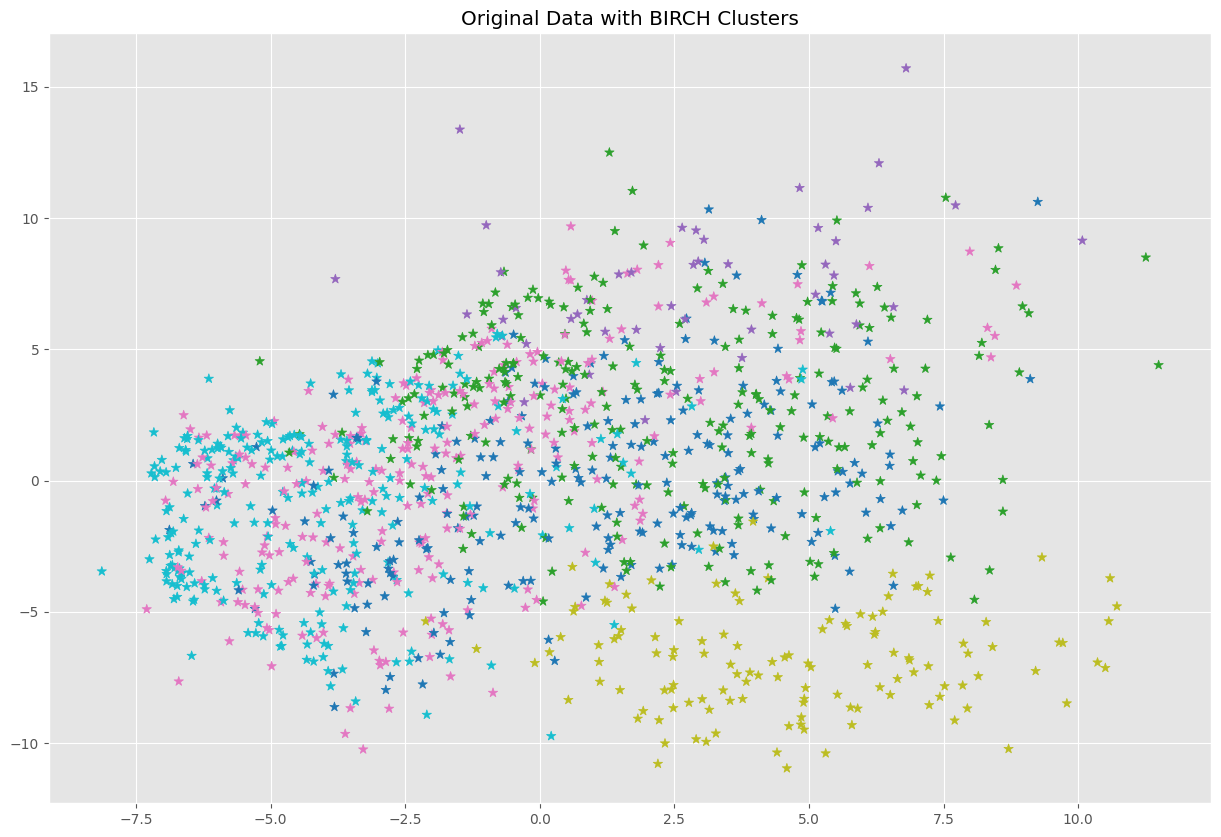

<Figure size 1500x1000 with 0 Axes>

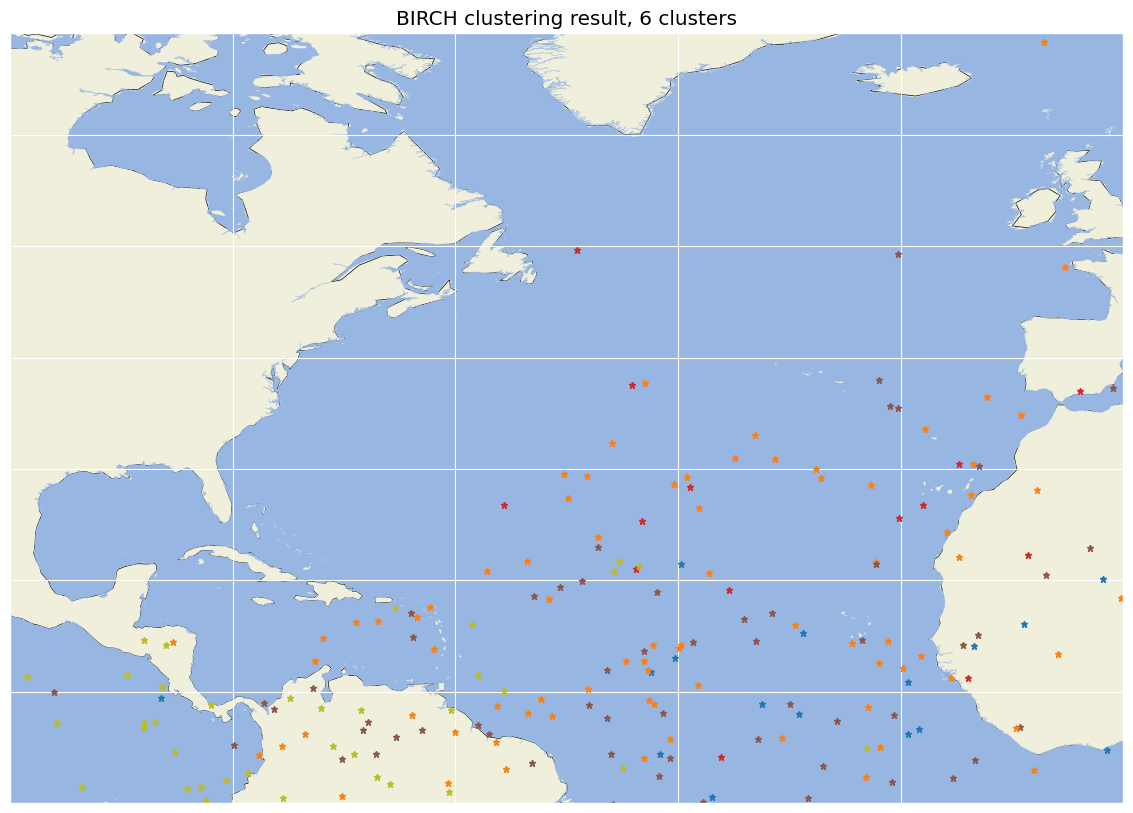


Cluster sizes:
Cluster 0: 232 points
Cluster 1: 264 points
Cluster 2: 47 points
Cluster 3: 267 points
Cluster 4: 127 points
Cluster 5: 267 points


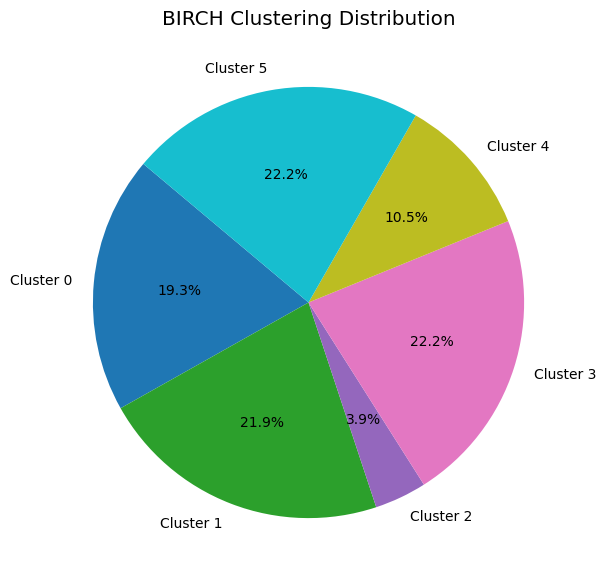

In [155]:
from sklearn.cluster import Birch


print("Shape of moment_lst_rescaled:", moment_lst_rescaled.shape)

x_min, x_max = np.min(moment_lst_rescaled[:, 0]), np.max(moment_lst_rescaled[:, 0])
y_min, y_max = np.min(moment_lst_rescaled[:, 1]), np.max(moment_lst_rescaled[:, 1])

original_ranges = {
   'x': (x_min, x_max),
   'y': (y_min, y_max)
}

def transform_to_geo(data, original_ranges):
   x_min, x_max = original_ranges['x']
   y_min, y_max = original_ranges['y']

   geo_x_min, geo_x_max = -180, 180
   geo_y_min, geo_y_max = -90, 90

   geo_coords = np.zeros_like(data)

   geo_coords[:, 0] = (data[:, 0] - x_min) / (x_max - x_min) * (geo_x_max - geo_x_min) + geo_x_min

   geo_coords[:, 1] = (data[:, 1] - y_min) / (y_max - y_min) * (geo_y_max - geo_y_min) + geo_y_min

   return geo_coords

birch = Birch(n_clusters=6)
labels_birch = birch.fit_predict(moment_lst_rescaled)

centroids = np.array([moment_lst_rescaled[labels_birch == i].mean(axis=0) for i in range(6)])
squared_distances = np.sum([np.linalg.norm(moment_lst_rescaled[i] - centroids[labels_birch[i]])**2
                         for i in range(len(moment_lst_rescaled))])
silhouette_avg_birch = silhouette_score(moment_lst_rescaled, labels_birch)

cluster_comp = pd.DataFrame(columns=["method", "SSD", "silhouette_avg"])
cluster_comp = pd.concat([cluster_comp, pd.DataFrame([{
   "method": "BIRCH",
   "SSD": squared_distances,
   "silhouette_avg": silhouette_avg_birch
}])], ignore_index=True)

moment_lst_geo = transform_to_geo(moment_lst_rescaled, original_ranges)

plt.figure(figsize=(15, 10))
plt.scatter(moment_lst_rescaled[:, 0], moment_lst_rescaled[:, 1],
          c=labels_birch,
          cmap='tab10',
          marker='*',
          s=50)
plt.title('Original Data with BIRCH Clusters')
plt.show()

plt.figure(figsize=(15, 10))
cmap = plt.get_cmap("tab10")
ax = map_background()

for i in range(len(moment_lst_geo)):
   ax.plot(moment_lst_geo[i, 0], moment_lst_geo[i, 1],
           color=cmap(labels_birch[i]/6),
           marker='*',
           markersize=5)

plt.title('BIRCH clustering result, 6 clusters')
plt.show()

unique, counts = np.unique(labels_birch, return_counts=True)
print("\nCluster sizes:")
for i, count in zip(unique, counts):
   print(f"Cluster {i}: {count} points")

cluster_pie(labels_birch, num_clusters=6, title='BIRCH Clustering Distribution')

### analysis for relevant clustering methods

  method            SSD  silhouette_avg
0  BIRCH  106719.692804         0.18182


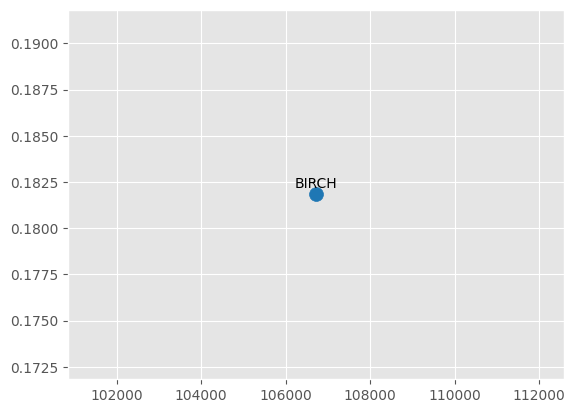

In [156]:
print(cluster_comp)

plt.scatter(cluster_comp['SSD'], cluster_comp['silhouette_avg'], color='tab:blue', s=100)
# Adding annotations
for i, method in enumerate(cluster_comp['method']):
    plt.annotate(method, (cluster_comp['SSD'][i], cluster_comp['silhouette_avg'][i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')



#### Analysis:
K-means has the lowest SSD (92823.718287), suggesting it formed relatively tighter clusters compared to the others. It also has the highest silhouette score (0.238624), which indicates that, although the clusters are compact, they may not be as well-separated as those from the other methods.

The other methods (Agglomerative, Spectral, and BIRCH) have lower silhouette scores, indicating that their clustering might not be as well-defined or well-separated.

## ML Based Clustering

In [157]:
!pip install fuzzy-c-means
!pip install minisom

#### Autoencoder-based k-means clustering

Shape of moment_lst_rescaled: (1204, 10)
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


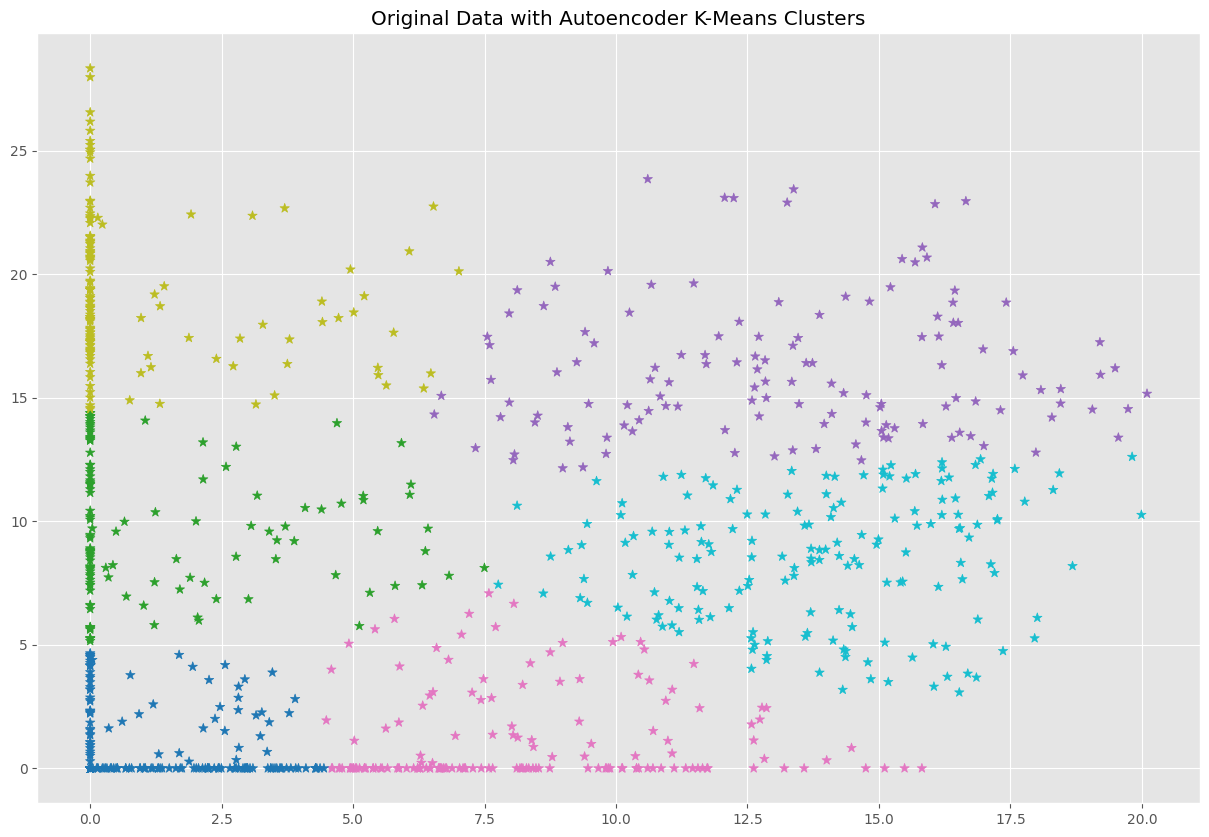

<Figure size 1500x1000 with 0 Axes>

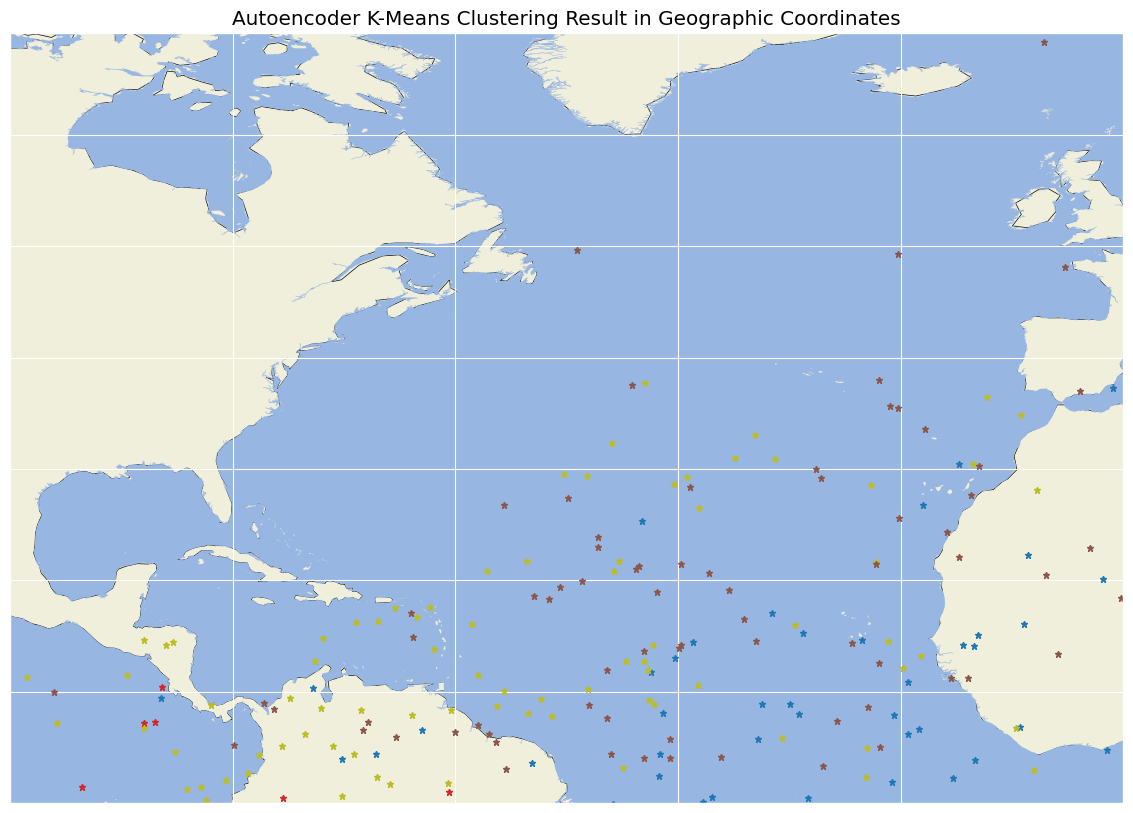


Cluster sizes:
Cluster 0: 489 points
Cluster 1: 123 points
Cluster 2: 133 points
Cluster 3: 154 points
Cluster 4: 135 points
Cluster 5: 170 points


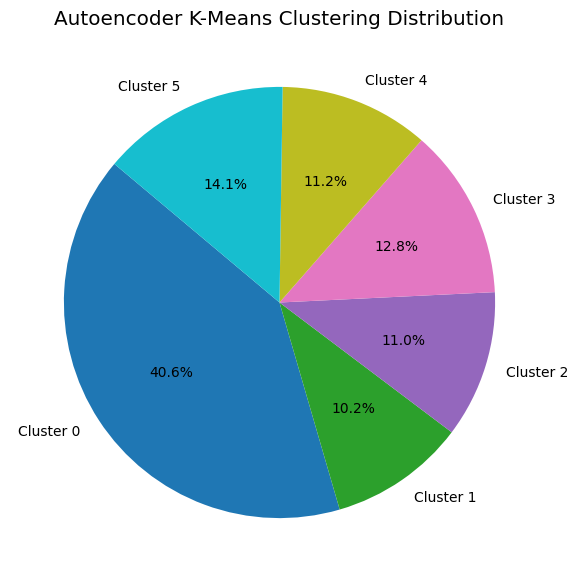


Metrics:
               method  silhouette_avg
Autoencoder + K-Means          0.5682


In [167]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

print("Shape of moment_lst_rescaled:", moment_lst_rescaled.shape)

x_min, x_max = np.min(moment_lst_rescaled[:, 0]), np.max(moment_lst_rescaled[:, 0])
y_min, y_max = np.min(moment_lst_rescaled[:, 1]), np.max(moment_lst_rescaled[:, 1])

original_ranges = {
    'x': (x_min, x_max),
    'y': (y_min, y_max)
}

def transform_to_geo(data, original_ranges):
    """Transform normalized data back to geographic coordinate space."""
    x_min, x_max = original_ranges['x']
    y_min, y_max = original_ranges['y']

    geo_x_min, geo_x_max = -180, 180
    geo_y_min, geo_y_max = -90, 90

    geo_coords = np.zeros_like(data)

    geo_coords[:, 0] = (data[:, 0] - x_min) / (x_max - x_min) * (geo_x_max - geo_x_min) + geo_x_min
    geo_coords[:, 1] = (data[:, 1] - y_min) / (y_max - y_min) * (geo_y_max - geo_y_min) + geo_y_min

    return geo_coords

input_dim = moment_lst_rescaled.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(moment_lst_rescaled, moment_lst_rescaled,
                epochs=50,
                batch_size=32,
                shuffle=True,
                verbose=0)

encoder = Model(input_layer, encoded)
latent_space = encoder.predict(moment_lst_rescaled)

kmeans = KMeans(n_clusters=6, random_state=0)
labels_autoencoder = kmeans.fit_predict(latent_space)

silhouette_avg_autoencoder = silhouette_score(latent_space, labels_autoencoder)

cluster_comp = pd.DataFrame([{
    "method": "Autoencoder + K-Means",
    "silhouette_avg": silhouette_avg_autoencoder
}])

plt.figure(figsize=(15, 10))
plt.scatter(latent_space[:, 0], latent_space[:, 1],
           c=labels_autoencoder,
           cmap='tab10',
           marker='*',
           s=50)
plt.title('Original Data with Autoencoder K-Means Clusters')
plt.show()

plt.figure(figsize=(15, 10))
cmap = plt.get_cmap("tab10")
ax = map_background()

for i in range(len(moment_lst_geo)):
    ax.plot(moment_lst_geo[i, 0], moment_lst_geo[i, 1],
            color=cmap(labels_autoencoder[i]/6),
            marker='*',
            markersize=5)

plt.title('Autoencoder K-Means Clustering Result in Geographic Coordinates')
plt.show()

unique, counts = np.unique(labels_autoencoder, return_counts=True)
print("\nCluster sizes:")
for i, count in zip(unique, counts):
    print(f"Cluster {i}: {count} points")

cluster_pie(labels_autoencoder, num_clusters=6, title='Autoencoder K-Means Clustering Distribution')

print("\nMetrics:")
print(cluster_comp.round(4).to_string(index=False))




#### Fuzzy Clustering

Shape of moment_lst_rescaled: (1204, 10)


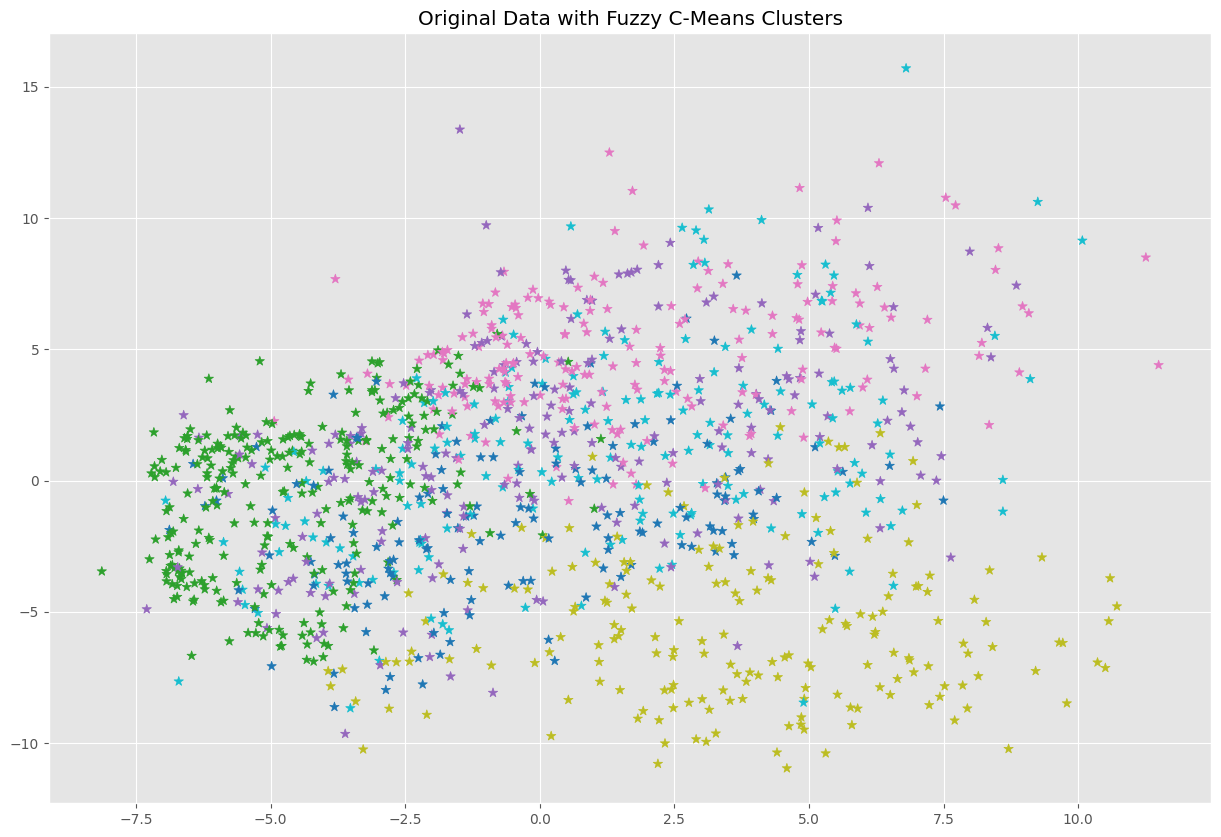

<Figure size 1500x1000 with 0 Axes>

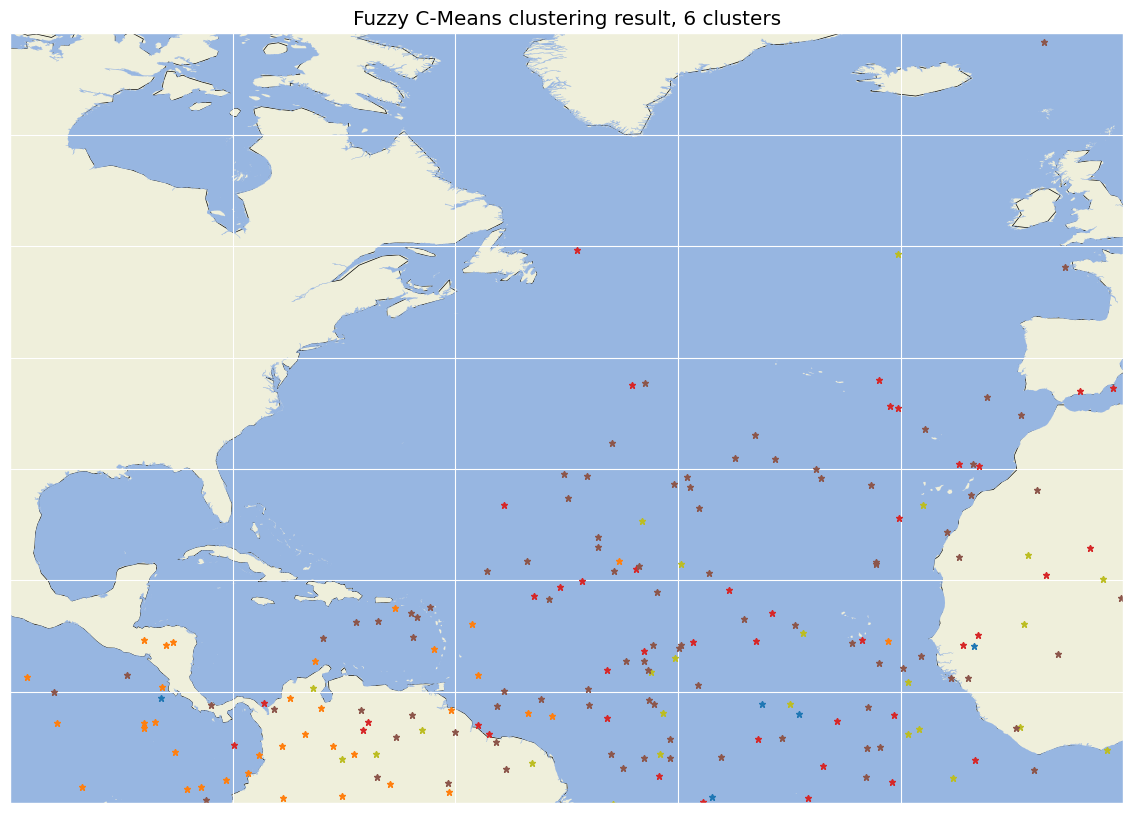


Fuzzy C-Means Cluster sizes:
Cluster 0: 149 points
Cluster 1: 276 points
Cluster 2: 214 points
Cluster 3: 191 points
Cluster 4: 189 points
Cluster 5: 185 points

Metrics:
       method         SSD  silhouette_avg
Fuzzy C-Means 107464.2922          0.1882


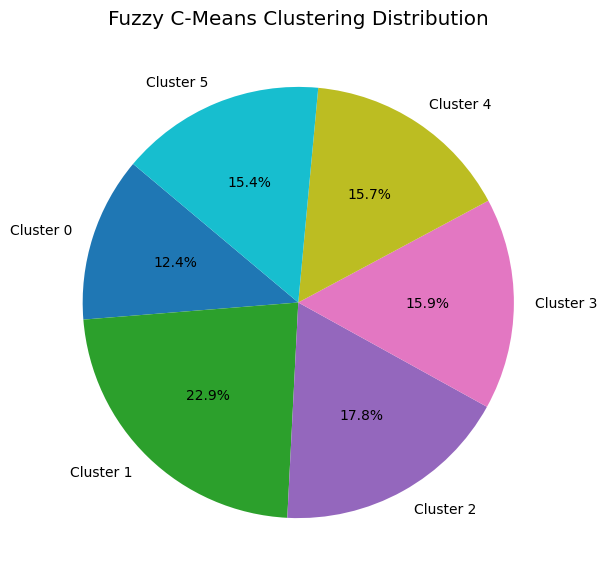

In [159]:
from fcmeans import FCM

print("Shape of moment_lst_rescaled:", moment_lst_rescaled.shape)

x_min, x_max = np.min(moment_lst_rescaled[:, 0]), np.max(moment_lst_rescaled[:, 0])
y_min, y_max = np.min(moment_lst_rescaled[:, 1]), np.max(moment_lst_rescaled[:, 1])

original_ranges = {
    'x': (x_min, x_max),
    'y': (y_min, y_max)
}

def transform_to_geo(data, original_ranges):
    x_min, x_max = original_ranges['x']
    y_min, y_max = original_ranges['y']

    geo_x_min, geo_x_max = -180, 180
    geo_y_min, geo_y_max = -90, 90

    geo_coords = np.zeros_like(data)

    geo_coords[:, 0] = (data[:, 0] - x_min) / (x_max - x_min) * (geo_x_max - geo_x_min) + geo_x_min

    geo_coords[:, 1] = (data[:, 1] - y_min) / (y_max - y_min) * (geo_y_max - geo_y_min) + geo_y_min

    return geo_coords

fcm = FCM(n_clusters=6)
fcm.fit(moment_lst_rescaled)
labels_fcm = fcm.predict(moment_lst_rescaled)

centroids_fcm = fcm.centers
squared_distances_fcm = np.sum([np.linalg.norm(moment_lst_rescaled[i] - centroids_fcm[labels_fcm[i]])**2
                              for i in range(len(moment_lst_rescaled))])
silhouette_avg_fcm = silhouette_score(moment_lst_rescaled, labels_fcm)

cluster_comp = pd.DataFrame([{
    "method": "Fuzzy C-Means",
    "SSD": squared_distances_fcm,
    "silhouette_avg": silhouette_avg_fcm
}])

moment_lst_geo = transform_to_geo(moment_lst_rescaled, original_ranges)

plt.figure(figsize=(15, 10))
plt.scatter(moment_lst_rescaled[:, 0], moment_lst_rescaled[:, 1],
           c=labels_fcm,
           cmap='tab10',
           marker='*',
           s=50)
plt.title('Original Data with Fuzzy C-Means Clusters')
plt.show()

plt.figure(figsize=(15, 10))
cmap = plt.get_cmap("tab10")
ax = map_background()

for i in range(len(moment_lst_geo)):
    ax.plot(moment_lst_geo[i, 0], moment_lst_geo[i, 1],
            color=cmap(labels_fcm[i]/6),
            marker='*',
            markersize=5)

plt.title('Fuzzy C-Means clustering result, 6 clusters')
plt.show()

unique, counts = np.unique(labels_fcm, return_counts=True)
print("\nFuzzy C-Means Cluster sizes:")
for i, count in zip(unique, counts):
    print(f"Cluster {i}: {count} points")

print("\nMetrics:")
print(cluster_comp.round(4).to_string(index=False))

cluster_pie(labels_fcm, num_clusters=6, title='Fuzzy C-Means Clustering Distribution')

#### Self Organizing Map

Shape of moment_lst_rescaled: (1204, 10)


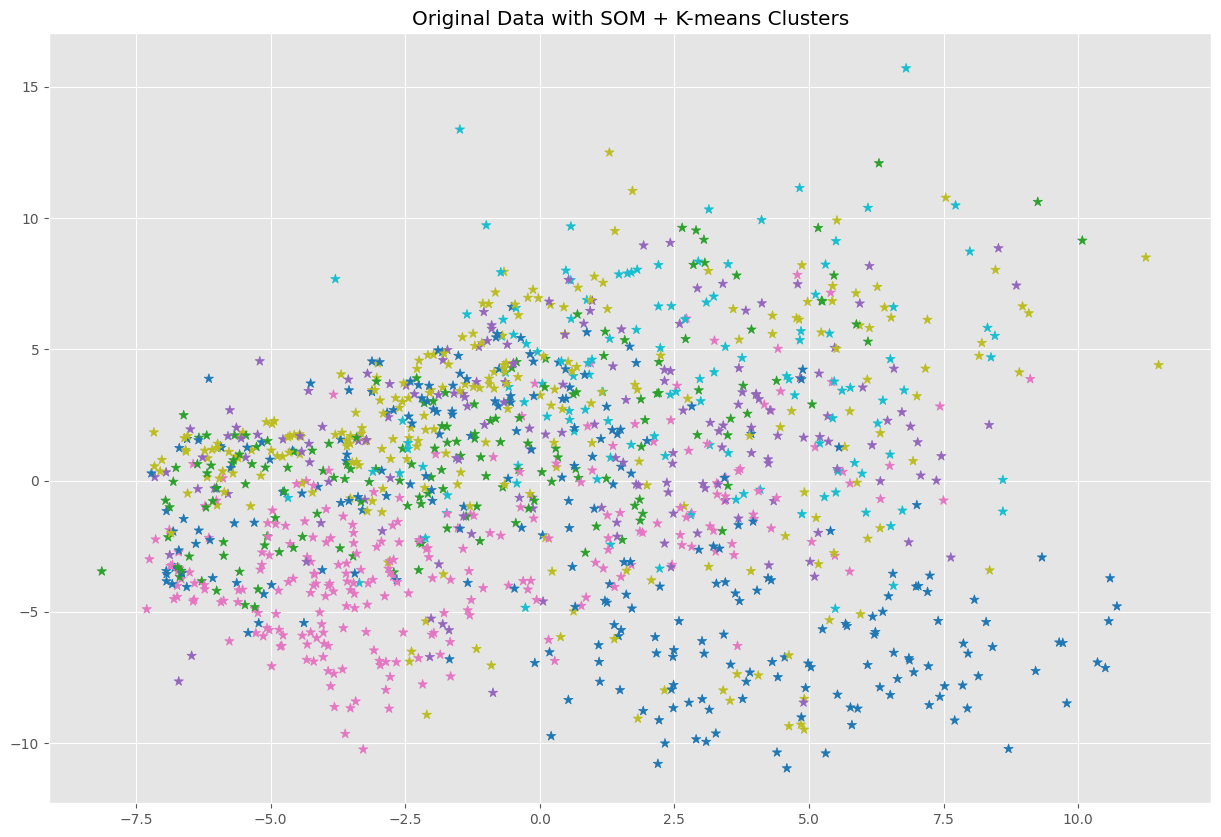

<Figure size 1500x1000 with 0 Axes>

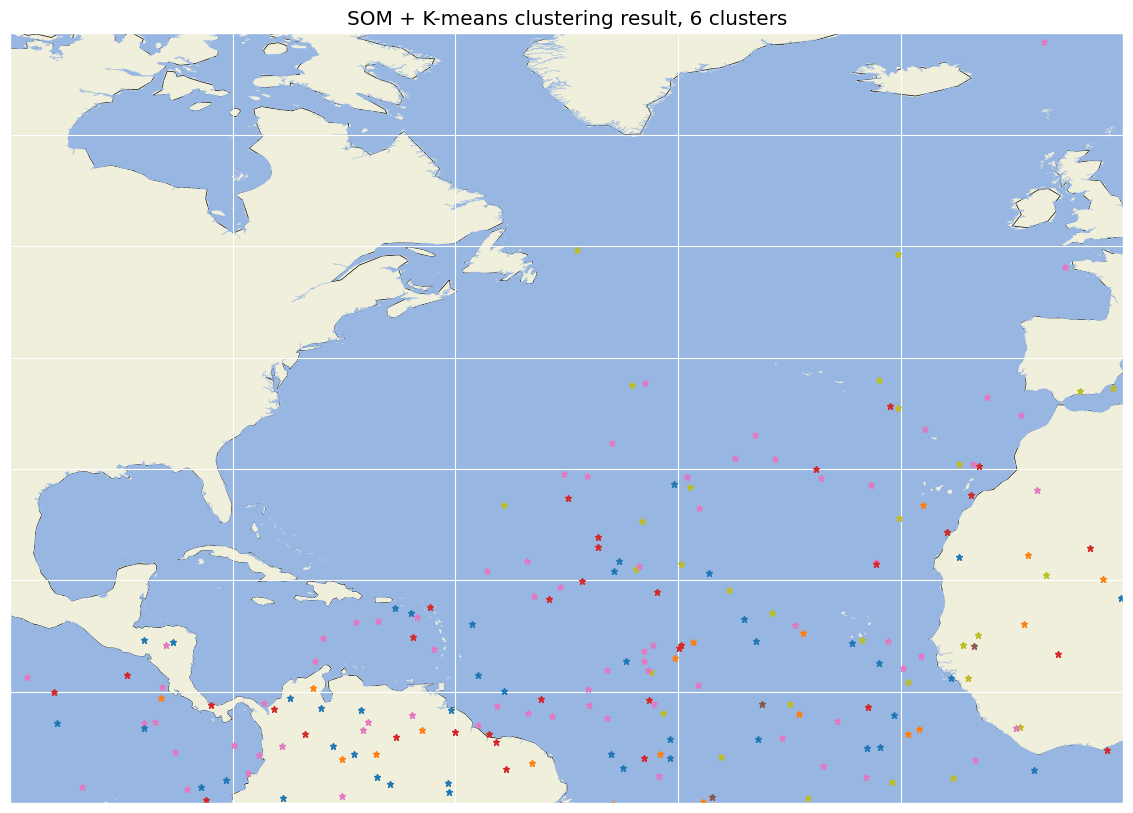


SOM + K-means Cluster sizes:
Cluster 0: 254 points
Cluster 1: 162 points
Cluster 2: 168 points
Cluster 3: 255 points
Cluster 4: 241 points
Cluster 5: 124 points

Metrics:
       method         SSD  silhouette_avg
SOM + K-means 166379.8021          0.0052


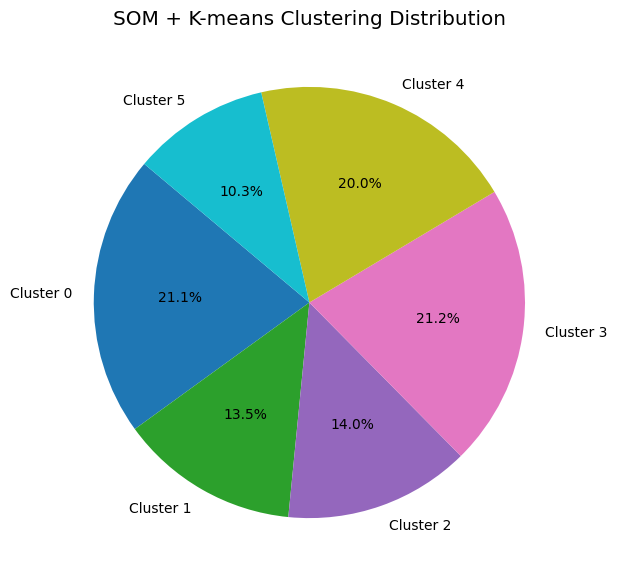

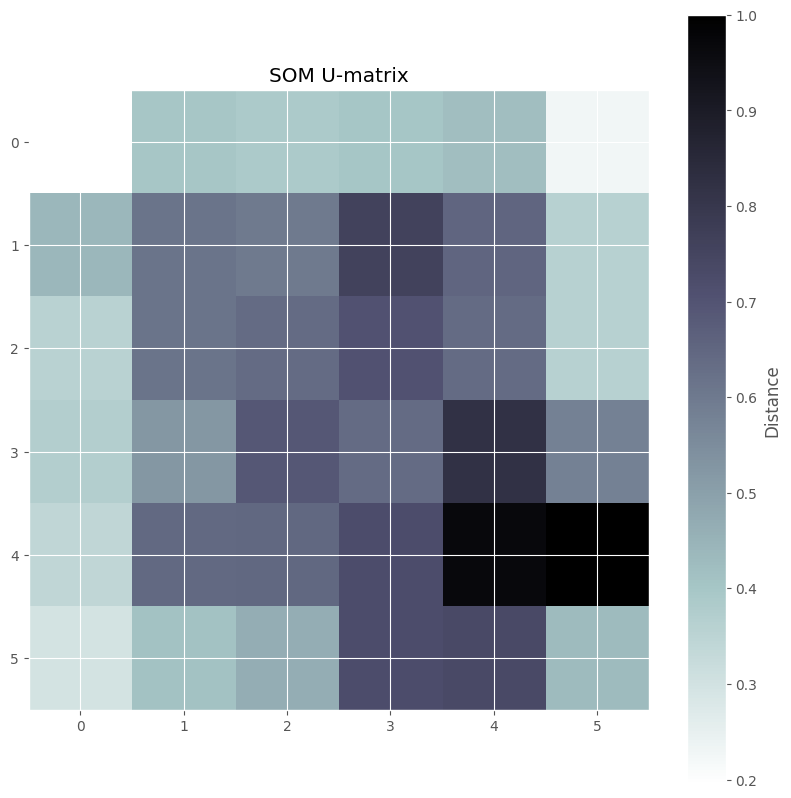

In [160]:
from minisom import MiniSom

print("Shape of moment_lst_rescaled:", moment_lst_rescaled.shape)

x_min, x_max = np.min(moment_lst_rescaled[:, 0]), np.max(moment_lst_rescaled[:, 0])
y_min, y_max = np.min(moment_lst_rescaled[:, 1]), np.max(moment_lst_rescaled[:, 1])

original_ranges = {
    'x': (x_min, x_max),
    'y': (y_min, y_max)
}

def transform_to_geo(data, original_ranges):
    x_min, x_max = original_ranges['x']
    y_min, y_max = original_ranges['y']

    geo_x_min, geo_x_max = -180, 180
    geo_y_min, geo_y_max = -90, 90

    geo_coords = np.zeros_like(data)

    geo_coords[:, 0] = (data[:, 0] - x_min) / (x_max - x_min) * (geo_x_max - geo_x_min) + geo_x_min
    geo_coords[:, 1] = (data[:, 1] - y_min) / (y_max - y_min) * (geo_y_max - geo_y_min) + geo_y_min

    return geo_coords

# SOM + K-means
som_x, som_y = 6, 6
som = MiniSom(x=som_x, y=som_y, input_len=moment_lst_rescaled.shape[1],
              sigma=1.0, learning_rate=0.5)
som.random_weights_init(moment_lst_rescaled)
som.train_random(moment_lst_rescaled, 1000)

bmus = np.array([som.winner(x) for x in moment_lst_rescaled])
bmu_indices = np.array([x[0] * som_y + x[1] for x in bmus])

kmeans_som = KMeans(n_clusters=6, random_state=0)
labels_som = kmeans_som.fit_predict(bmu_indices.reshape(-1, 1))

centroids_som = np.array([moment_lst_rescaled[labels_som == i].mean(axis=0) for i in range(6)])
squared_distances_som = np.sum([np.linalg.norm(moment_lst_rescaled[i] - centroids_som[labels_som[i]])**2
                              for i in range(len(moment_lst_rescaled))])
silhouette_avg_som = silhouette_score(moment_lst_rescaled, labels_som)

cluster_comp = pd.DataFrame([{
    "method": "SOM + K-means",
    "SSD": squared_distances_som,
    "silhouette_avg": silhouette_avg_som
}])

moment_lst_geo = transform_to_geo(moment_lst_rescaled, original_ranges)

plt.figure(figsize=(15, 10))
plt.scatter(moment_lst_rescaled[:, 0], moment_lst_rescaled[:, 1],
           c=labels_som,
           cmap='tab10',
           marker='*',
           s=50)
plt.title('Original Data with SOM + K-means Clusters')
plt.show()

plt.figure(figsize=(15, 10))
cmap = plt.get_cmap("tab10")
ax = map_background()

for i in range(len(moment_lst_geo)):
    ax.plot(moment_lst_geo[i, 0], moment_lst_geo[i, 1],
            color=cmap(labels_som[i]/6),
            marker='*',
            markersize=5)

plt.title('SOM + K-means clustering result, 6 clusters')
plt.show()
unique, counts = np.unique(labels_som, return_counts=True)
print("\nSOM + K-means Cluster sizes:")
for i, count in zip(unique, counts):
    print(f"Cluster {i}: {count} points")

print("\nMetrics:")
print(cluster_comp.round(4).to_string(index=False))

cluster_pie(labels_som, num_clusters=6, title='SOM + K-means Clustering Distribution')

plt.figure(figsize=(10, 10))
plt.imshow(som.distance_map(), cmap='bone_r')
plt.colorbar(label='Distance')
plt.title('SOM U-matrix')
plt.show()

## Step 4: Cluster analysis and evaluation

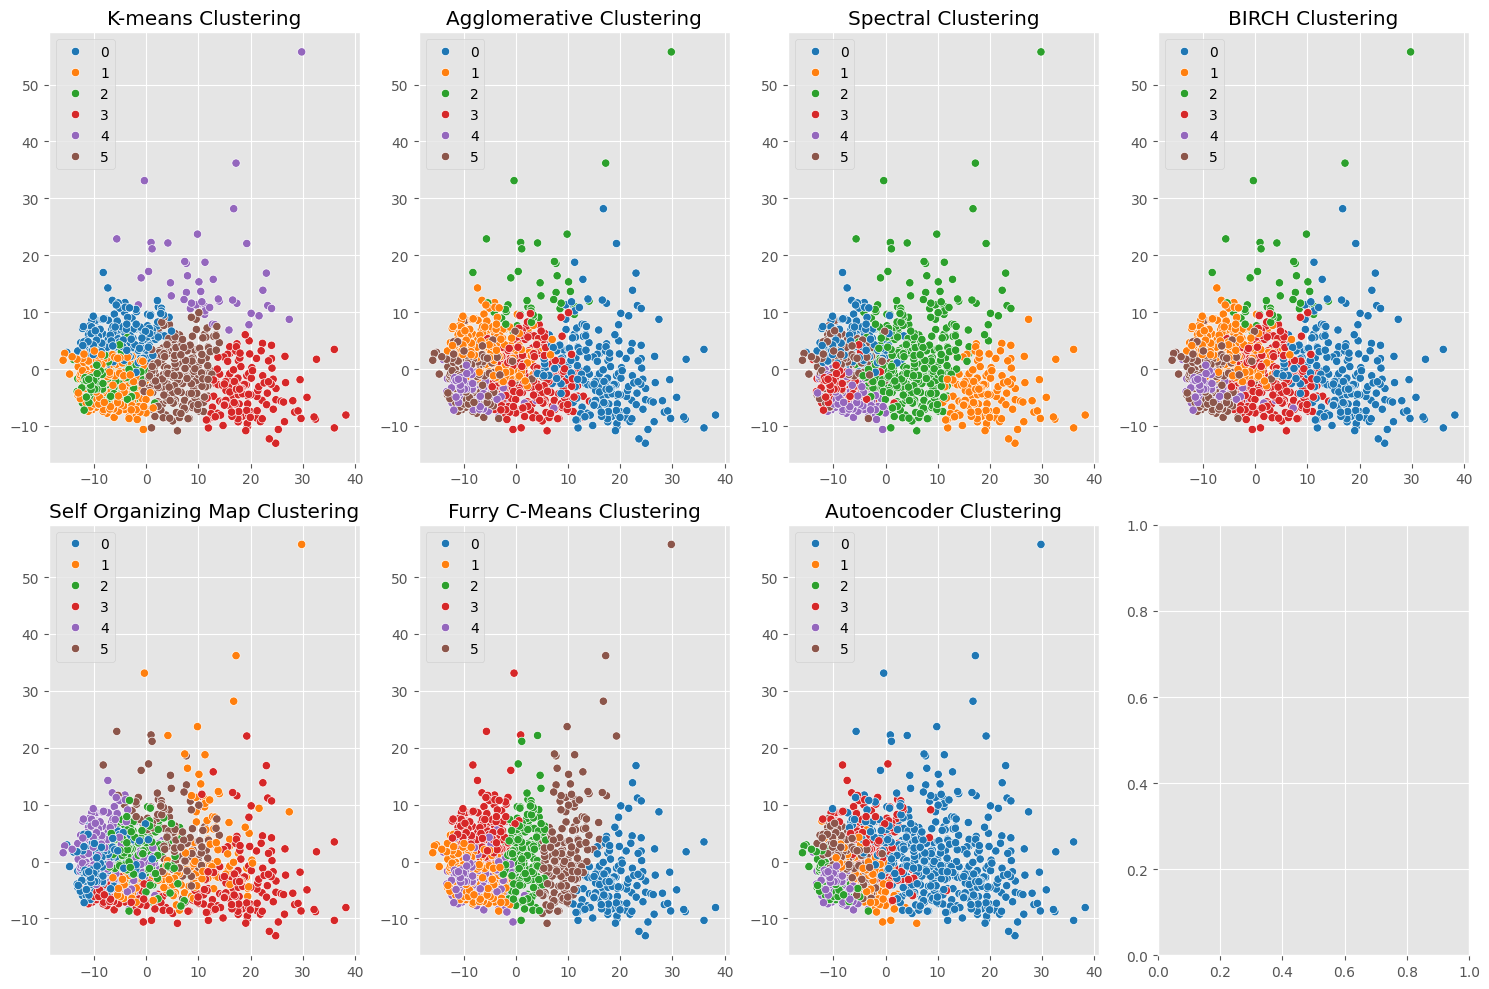

In [169]:
cluster_labels = {
    "K-means": labels_kmeans,
    "Agglomerative": labels_agg,
    "Spectral": labels_spectral,
    "BIRCH": labels_birch,
    "Self Organizing Map": labels_som,
    "Furry C-Means": labels_fcm,
    "Autoencoder": labels_autoencoder,
}

# Using PCA for visualization
pca = PCA(n_components=2)
moment_pca = pca.fit_transform(moment_lst_rescaled)
latent_pca = pca.fit_transform(latent_space)

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

for i, (method, labels) in enumerate(cluster_labels.items()):
    ax = axes[i]
    sns.scatterplot(x=moment_pca[:, 0], y=moment_pca[:, 1], hue=labels, palette="tab10", ax=ax)
    ax.set_title(f"{method} Clustering")

plt.tight_layout()
plt.show()


From the above results, we can see that K-Means, Agglomerative, and BIRCH produce well-separated clusters that are compact and distinct.
Spectral Clustering has similar results but shows some instability in separation.
Fuzzy C-Means allows more flexibility with soft clustering, which may explain the increased overlap.
SOM (Self-Organizing Map) provides a structured organization but does not always produce clear separation.
Autoencoder + K-Means seems to have failed to cluster properly, indicating an issue with feature representation.